# init

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # for XGBoost
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt 

from sklearn.ensemble        import RandomForestClassifier
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier
from sklearn.linear_model    import LogisticRegression

from sklearn                 import datasets, metrics
from sklearn.model_selection import train_test_split
from umap                    import UMAP


In [3]:
# import domestic lib
import ppap.tabular_utility        as ppap_tab_utl
import ppap.tabular_classification as ppap_tab_cls

import importlib
importlib.reload(ppap_tab_utl)
importlib.reload(ppap_tab_cls)


<module 'ppap.tabular_classification' from '/Users/mucunwuxian/MICIN/20190709_houken_x_PPAP/PPAP/ppap/tabular_classification.py'>

In [4]:
# 
input_csv_dir  = './data/titanic'
 
# 
output_log_dir = './log'

# 
os.makedirs(output_log_dir, exist_ok=True)


In [5]:
# pandas display option (ajustable)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

#
np.set_printoptions(threshold=2000)

# 
plt.rcParams["font.size"] = 12


# Pre-Process

data download from https://www.kaggle.com/c/titanic/data<br>
ref https://qiita.com/suzumi/items/8ce18bc90c942663d1e6

In [6]:
# load titanic data from kaggle
df_Xy       = pd.read_csv('%s/train.csv' % input_csv_dir)
column_name = df_Xy.columns

#
print(df_Xy.shape)
df_Xy.head(5)


(891, 12)


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

[info]<br>
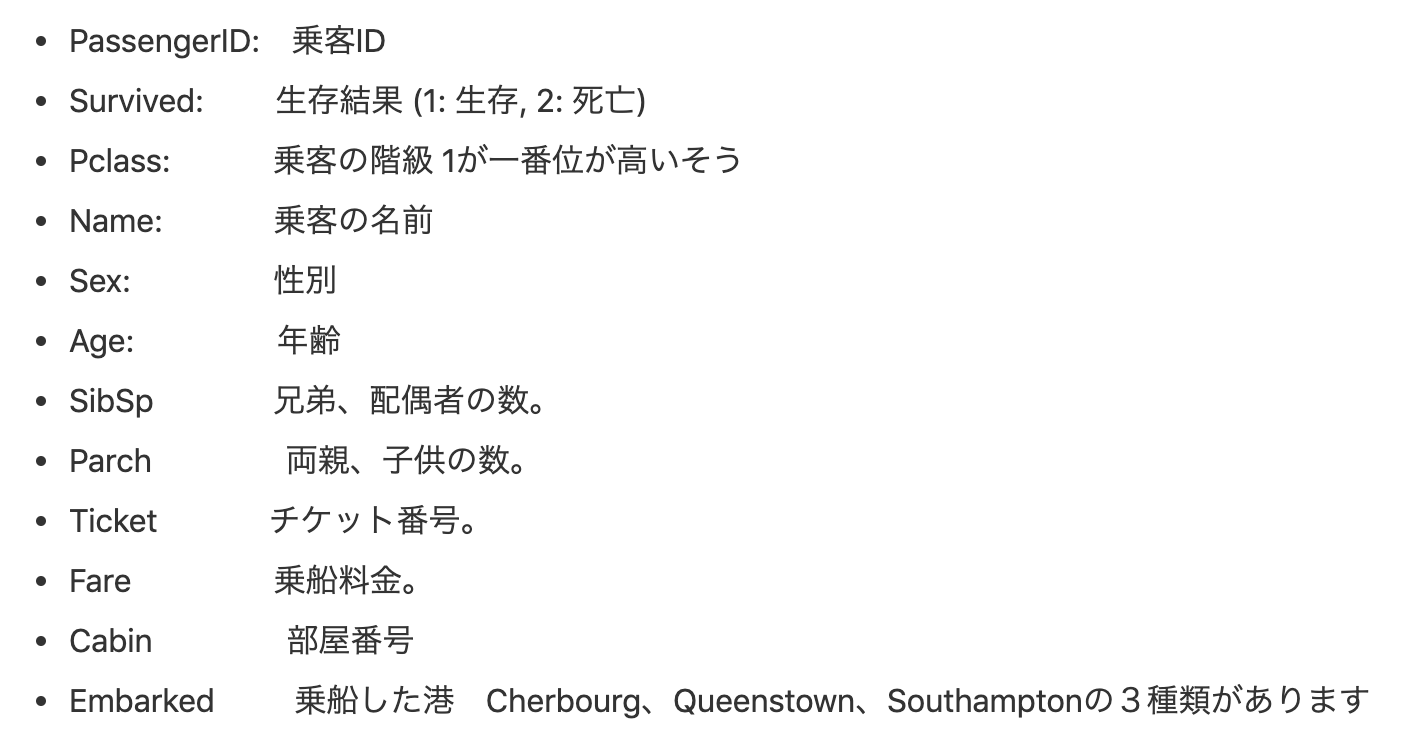


include nan column is ...

------------------------------------------------------------
  - Age -> 0.19865
  - Cabin -> 0.77104
  - Embarked -> 0.00224


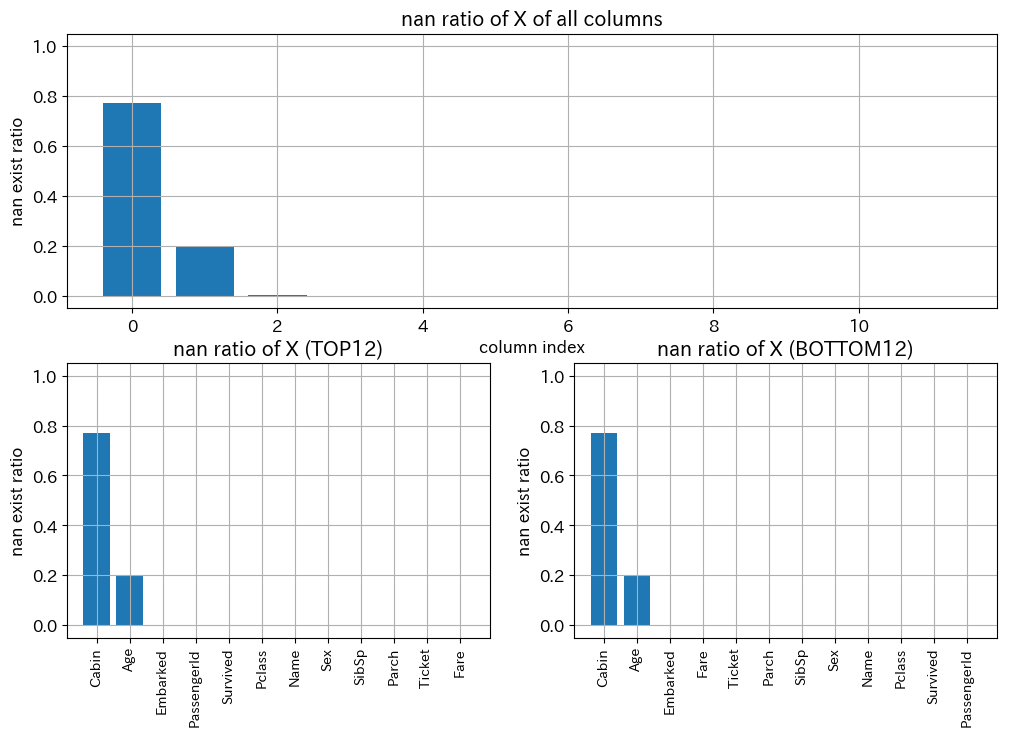

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.1986532 , 0.        , 0.        , 0.        , 0.        ,
       0.77104377, 0.00224467])

In [7]:
# [STEP 1]
# check nan ratio (vertical)
ppap_tab_utl.check_nan_ratio_vert(X = df_Xy)


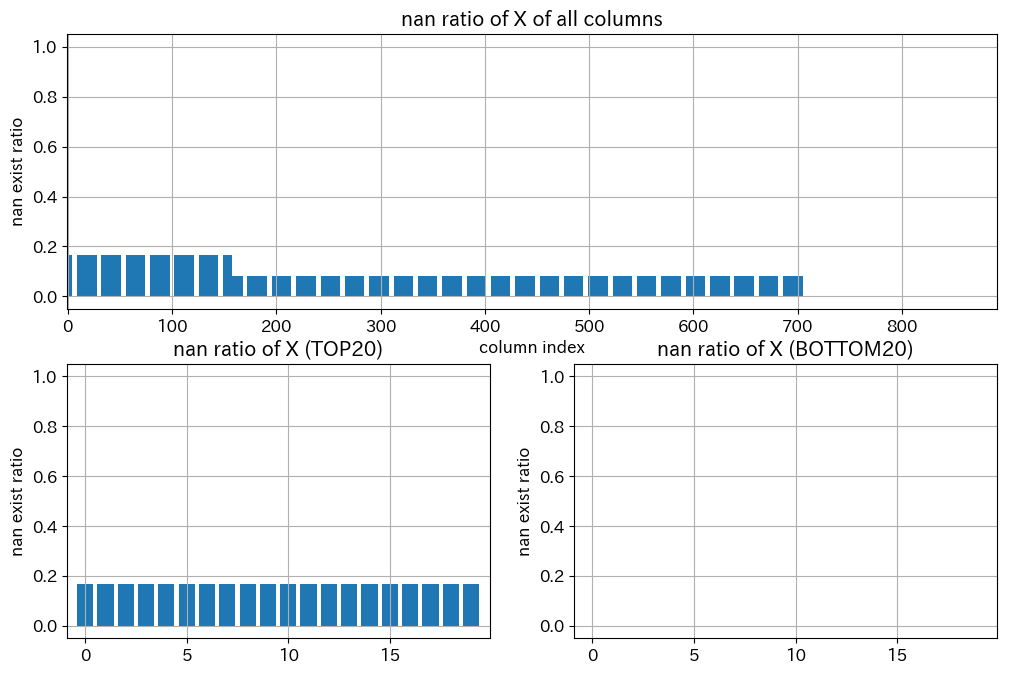

In [8]:
# [STEP 2]
# check nan ratio (horizontal)
nan_ratio = ppap_tab_utl.check_nan_ratio_horz(X = df_Xy)


In [9]:
# [STEP 3]
# value state check
ppap_tab_utl.check_value_count(X = df_Xy)



numeric ratio is ...

------------------------------------------------------------
  - PassengerId -> 1.00000
  - Survived -> 1.00000
  - Pclass -> 1.00000
  - Name -> 0.00000
  - Sex -> 0.00000
  - Age -> 1.00000
  - SibSp -> 1.00000
  - Parch -> 1.00000
  - Ticket -> 0.74186
  - Fare -> 1.00000
  - Cabin -> 0.00000
  - Embarked -> 0.00000



value pattern is ...

------------------------------------------------------------
[PassengerId]
891    1
293    1
304    1
303    1
302    1
301    1
300    1
299    1
298    1
297    1
296    1
295    1
294    1
292    1
306    1
291    1
290    1
289    1
288    1
287    1
286    1
285    1
284    1
283    1
282    1
281    1
305    1
307    1
279    1
321    1
332    1
331    1
330    1
329    1
328    1
327    1
326    1
325    1
324    1
323    1
322    1
320    1
308    1
319    1
318    1
317    1
316    1
315    1
314    1
313    1
312    1
311    1
310    1
309    1
280    1
278    1
223    1
237    1
248    1
247    1
246    1
245    

In [10]:
# [STEP 4]
# organize data

# 
print('\nbefore organize shape is (%d, %d)' % np.shape(df_Xy))
# exec
df_Xy = ppap_tab_utl.organize_data(X = df_Xy)
# 
print('\nafter organize shape is (%d, %d)' % np.shape(df_Xy))
df_Xy.head(10)



before organize shape is (891, 12)

delete one-pattern column...
  - none ...

delete overlap column...
  - none ...

after organize shape is (891, 12)


PassengerId Survived Pclass  \
0           1        0      3   
1           2        1      1   
2           3        1      3   
3           4        1      1   
4           5        0      3   
5           6        0      3   
6           7        0      1   
7           8        0      3   
8           9        1      3   
9          10        1      2   

                                                Name     Sex  Age SibSp Parch  \
0                            Braund, Mr. Owen Harris    male   22     1     0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38     1     0   
2                             Heikkinen, Miss. Laina  female   26     0     0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35     1     0   
4                           Allen, Mr. William Henry    male   35     0     0   
5                                   Moran, Mr. James    male  NaN     0     0   
6                            McCarthy, Mr. Timothy J    male   54     0     0   
7                     Palsson, Master. Gosta Leonard    male    2     3     1   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female   27     0     2   
9                Nasser, Mrs. Nicholas (Adele Achem)  female   14     1     0   

             Ticket     Fare Cabin Embarked  
0         A/5 21171     7.25   NaN        S  
1          PC 17599  71.2833   C85        C  
2  STON/O2. 3101282    7.925   NaN        S  
3            113803     53.1  C123        S  
4            373450     8.05   NaN        S  
5            330877   8.4583   NaN        Q  
6             17463  51.8625   E46        S  
7            349909   21.075   NaN        S  
8            347742  11.1333   NaN        S  
9            237736  30.0708   NaN        C

In [11]:
# [STEP 5]
# quantize

# column assign
column_1k   = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
column_disc = ['Age', 'Fare']
column_bow  = []

# exec
df_Xy_, _ = ppap_tab_utl.one_k_code_and_disc(X             = df_Xy, 
                                             column_1k     = column_1k, 
                                             column_disc   = column_disc,
                                             column_bow    = column_bow,  
                                             disc_bins_num = 50)
# view
df_Xy_.head(10)



1-k conding or discretization [start time is 2019-07-10 13:50:58.657514]
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
                              [end time is 2019-07-10 13:50:59.179816]



after quantize size = (891, 123)


Pclass_c[1]  Pclass_c[2]  Pclass_c[3]  Sex_c[female]  Age_c[(nan)]  \
0            0            0            1              0           0.0   
1            1            0            0              1           0.0   
2            0            0            1              1           0.0   
3            1            0            0              1           0.0   
4            0            0            1              0           0.0   
5            0            0            1              0           1.0   
6            1            0            0              0           0.0   
7            0            0            1              0           0.0   
8            0            0            1              1           0.0   
9            0            1            0              1           0.0   

   Age_v[0.000-1.600]  Age_v[1.600-3.200]  Age_v[3.200-4.800]  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   
5                 0.0                 0.0                 0.0   
6                 0.0                 0.0                 0.0   
7                 0.0                 1.0                 0.0   
8                 0.0                 0.0                 0.0   
9                 0.0                 0.0                 0.0   

   Age_v[4.800-6.400]  Age_v[6.400-8.000]  Age_v[8.000-9.600]  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   
5                 0.0                 0.0                 0.0   
6                 0.0                 0.0                 0.0   
7                 0.0                 0.0                 0.0   
8                 0.0                 0.0                 0.0   
9                 0.0                 0.0                 0.0   

   Age_v[9.600-11.200]  Age_v[11.200-12.800]  Age_v[12.800-14.400]  \
0                  0.0                   0.0                   0.0   
1                  0.0                   0.0                   0.0   
2                  0.0                   0.0                   0.0   
3                  0.0                   0.0                   0.0   
4                  0.0                   0.0                   0.0   
5                  0.0                   0.0                   0.0   
6                  0.0                   0.0                   0.0   
7                  0.0                   0.0                   0.0   
8                  0.0                   0.0                   0.0   
9                  0.0                   0.0                   1.0   

   Age_v[14.400-16.000]  Age_v[16.000-17.600]  Age_v[17.600-19.200]  \
0                   0.0                   0.0                   0.0   
1                   0.0                   0.0                   0.0   
2                   0.0                   0.0                   0.0   
3                   0.0                   0.0                   0.0   
4                   0.0                   0.0                   0.0   
5                   0.0                   0.0                   0.0   
6                   0.0                   0.0                   0.0   
7                   0.0                   0.0                   0.0   
8                   0.0                   0.0                   0.0   
9                   0.0                   0.0                   0.0   

   Age_v[19.200-20.800]  Age_v[20.800-22.400]  Age_v[22.400-24.000]  \
0                   0.0                   1.0                   0.0   
1                   0.0                   0.0                   0.0   
2

In [12]:
# [STEP 6]
# treatment
column_y    = 'Survived'

column_name = df_Xy_.columns
X           = df_Xy_.values
y           = df_Xy.loc[:, column_y].values.astype('float')

# print size of X and y
print('column_name = \n%s(%d)' % (column_name, len(column_name)))
print('np.shape(X) = (%d, %d)' % np.shape(X))
print('np.shape(y) = (%d)'     % np.shape(y))

# for visualize
df_X_tmp = pd.DataFrame(X, columns=column_name)
df_X_tmp.head(10)


column_name = 
Index(['Pclass_c[1]', 'Pclass_c[2]', 'Pclass_c[3]', 'Sex_c[female]',
       'Age_c[(nan)]', 'Age_v[0.000-1.600]', 'Age_v[1.600-3.200]',
       'Age_v[3.200-4.800]', 'Age_v[4.800-6.400]', 'Age_v[6.400-8.000]',
       ...
       'Fare_v[450.850-461.096]', 'Fare_v[461.096-471.343]',
       'Fare_v[471.343-481.589]', 'Fare_v[481.589-491.836]',
       'Fare_v[491.836-502.083]', 'Fare_v[502.083-512.329]',
       'Embarked_c[(nan)]', 'Embarked_c[c]', 'Embarked_c[q]', 'Embarked_c[s]'],
      dtype='object', length=123)(123)
np.shape(X) = (891, 123)
np.shape(y) = (891)


Pclass_c[1]  Pclass_c[2]  Pclass_c[3]  Sex_c[female]  Age_c[(nan)]  \
0          0.0          0.0          1.0            0.0           0.0   
1          1.0          0.0          0.0            1.0           0.0   
2          0.0          0.0          1.0            1.0           0.0   
3          1.0          0.0          0.0            1.0           0.0   
4          0.0          0.0          1.0            0.0           0.0   
5          0.0          0.0          1.0            0.0           1.0   
6          1.0          0.0          0.0            0.0           0.0   
7          0.0          0.0          1.0            0.0           0.0   
8          0.0          0.0          1.0            1.0           0.0   
9          0.0          1.0          0.0            1.0           0.0   

   Age_v[0.000-1.600]  Age_v[1.600-3.200]  Age_v[3.200-4.800]  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   
5                 0.0                 0.0                 0.0   
6                 0.0                 0.0                 0.0   
7                 0.0                 1.0                 0.0   
8                 0.0                 0.0                 0.0   
9                 0.0                 0.0                 0.0   

   Age_v[4.800-6.400]  Age_v[6.400-8.000]  Age_v[8.000-9.600]  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   
5                 0.0                 0.0                 0.0   
6                 0.0                 0.0                 0.0   
7                 0.0                 0.0                 0.0   
8                 0.0                 0.0                 0.0   
9                 0.0                 0.0                 0.0   

   Age_v[9.600-11.200]  Age_v[11.200-12.800]  Age_v[12.800-14.400]  \
0                  0.0                   0.0                   0.0   
1                  0.0                   0.0                   0.0   
2                  0.0                   0.0                   0.0   
3                  0.0                   0.0                   0.0   
4                  0.0                   0.0                   0.0   
5                  0.0                   0.0                   0.0   
6                  0.0                   0.0                   0.0   
7                  0.0                   0.0                   0.0   
8                  0.0                   0.0                   0.0   
9                  0.0                   0.0                   1.0   

   Age_v[14.400-16.000]  Age_v[16.000-17.600]  Age_v[17.600-19.200]  \
0                   0.0                   0.0                   0.0   
1                   0.0                   0.0                   0.0   
2                   0.0                   0.0                   0.0   
3                   0.0                   0.0                   0.0   
4                   0.0                   0.0                   0.0   
5                   0.0                   0.0                   0.0   
6                   0.0                   0.0                   0.0   
7                   0.0                   0.0                   0.0   
8                   0.0                   0.0                   0.0   
9                   0.0                   0.0                   0.0   

   Age_v[19.200-20.800]  Age_v[20.800-22.400]  Age_v[22.400-24.000]  \
0                   0.0                   1.0                   0.0   
1                   0.0                   0.0                   0.0   
2

In [13]:
# # [STEP 7]
# # regularization
# X_reg, X_min, X_max = ppap_tab_utl.X_regularization(X)

# # 
# print('np.shape(X) = (%d, %d)' % np.shape(X_reg))
# print('min = ')
# print(np.min(X_reg, axis=0))
# print('max = ')
# print(np.max(X_reg, axis=0))


In [14]:
# # [STEP 8]
# # make co-occurrence feat
# X, column_name = ppap_tab_utl.cooc_feat(X           = X_reg, 
#                                        column_name = column_name)

# # print size of X and y
# print('column_name = \n%s(%d)' % (column_name, len(column_name)))
# print('np.shape(X) = (%d, %d)' % np.shape(X))

# # for visualize
# df_X_tmp = pd.DataFrame(X, columns=column_name)
# df_X_tmp.head(10)


Total data num    :    891件
Positive data num :    342件 (38.38%)
Negative data num :    549件 (61.62%)


leakage check


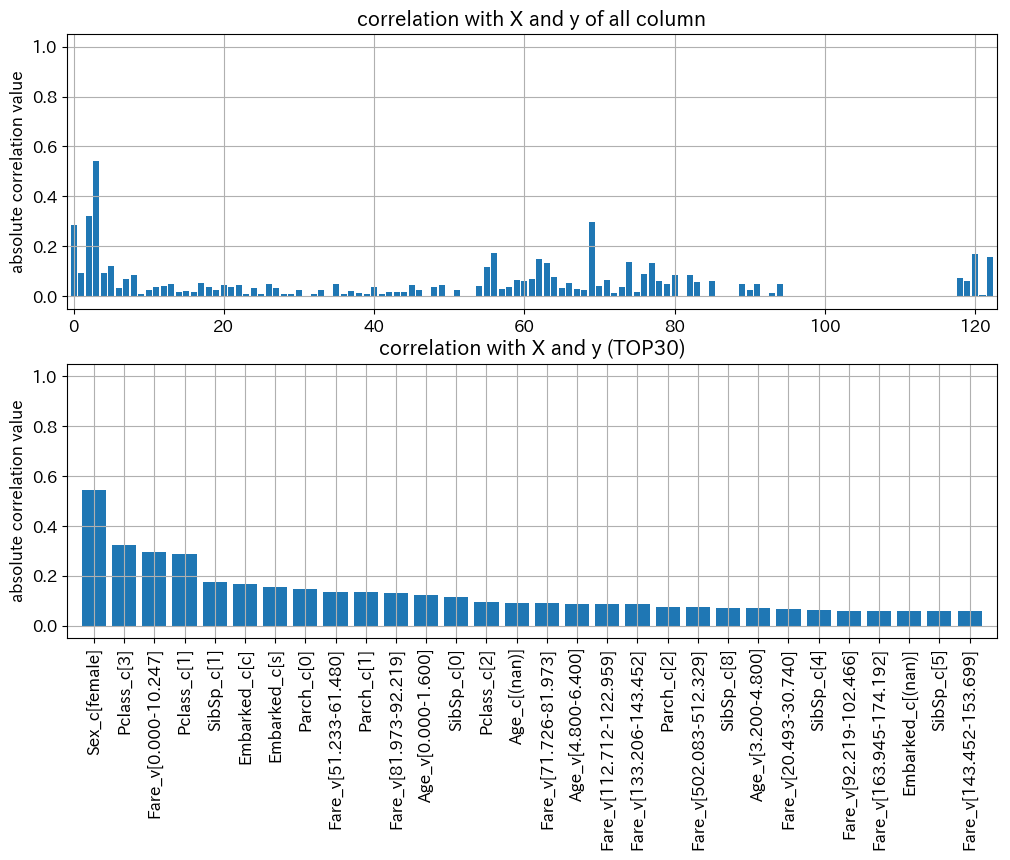



cross plot
(high corr TOP10)
---------------------------------------------
[3]


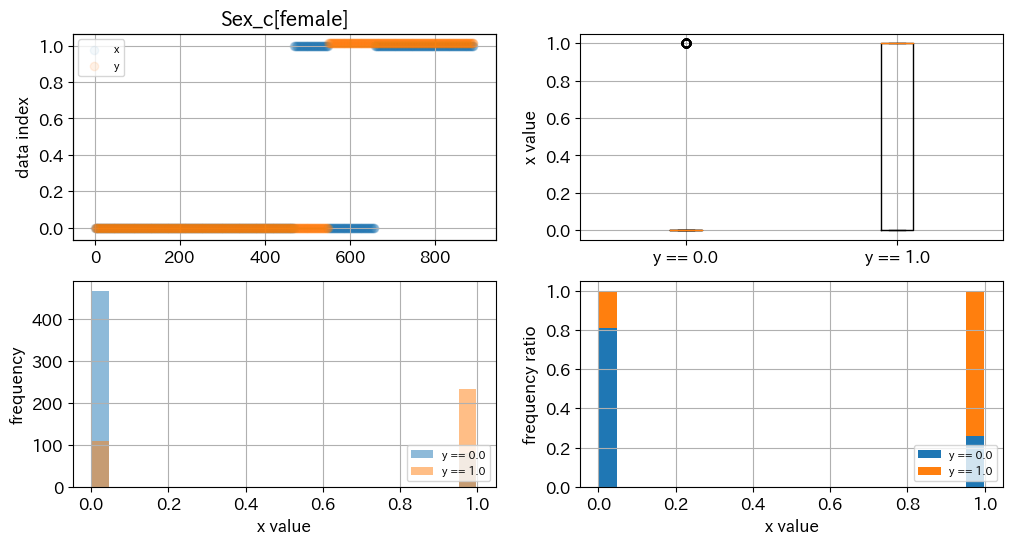



---------------------------------------------
[2]


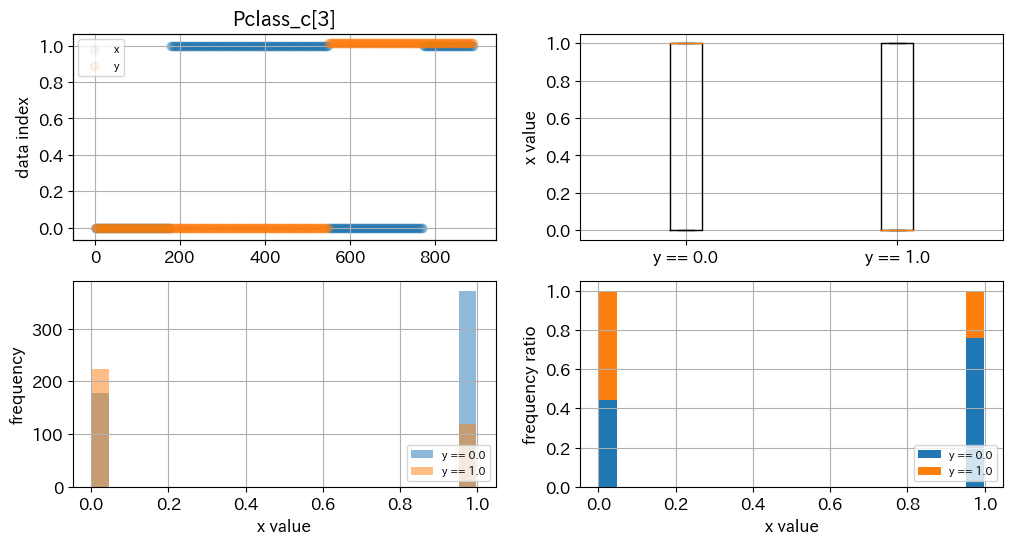



---------------------------------------------
[69]


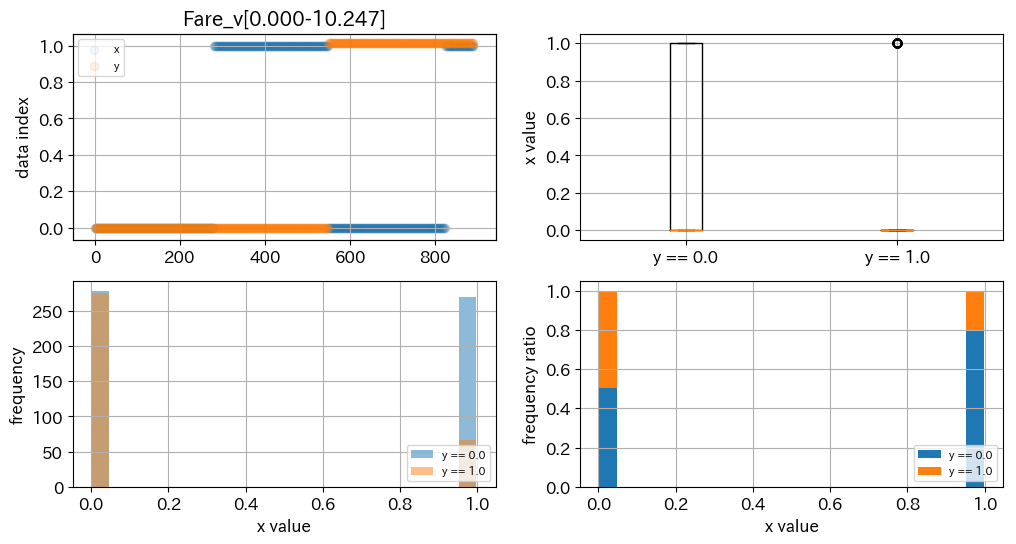



---------------------------------------------
[0]


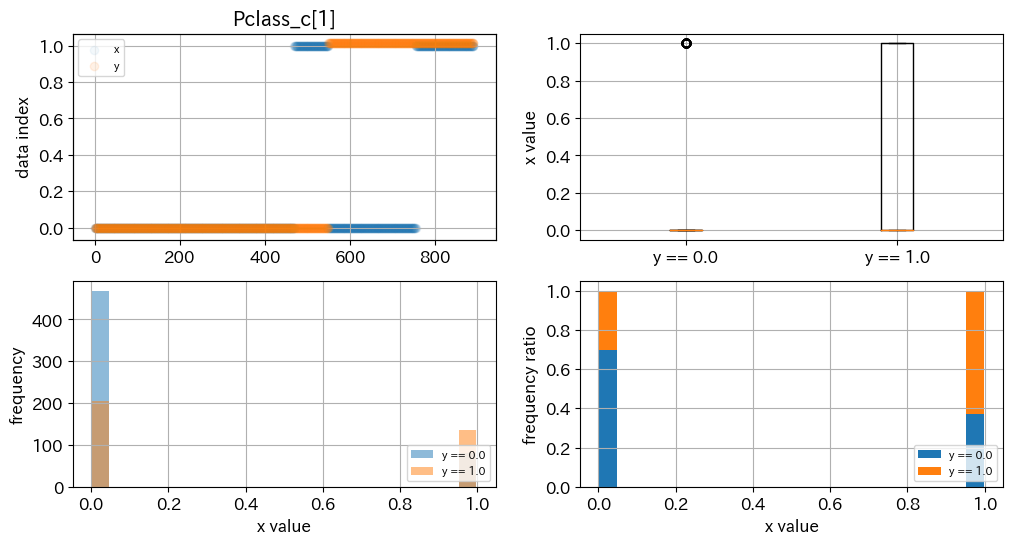



---------------------------------------------
[56]


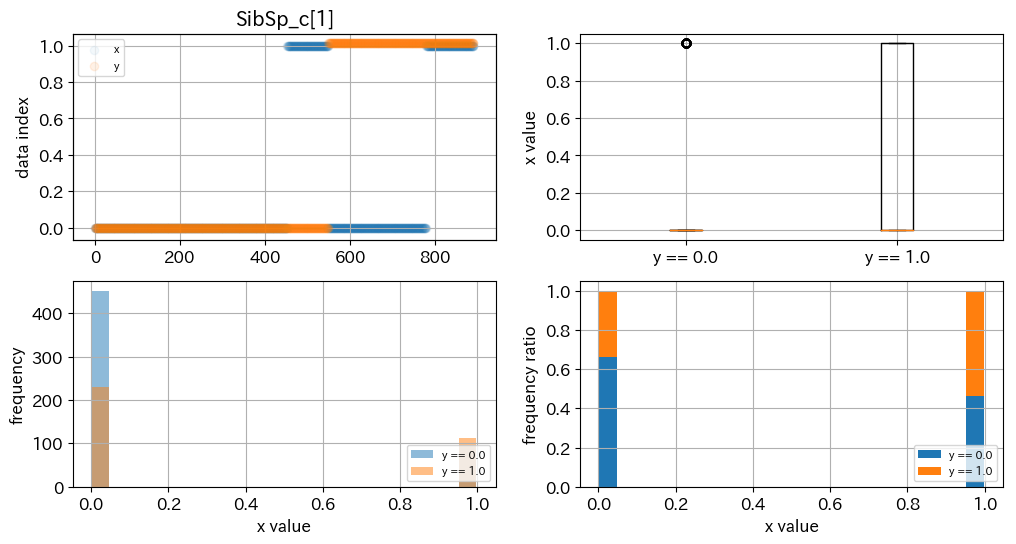



---------------------------------------------
[120]


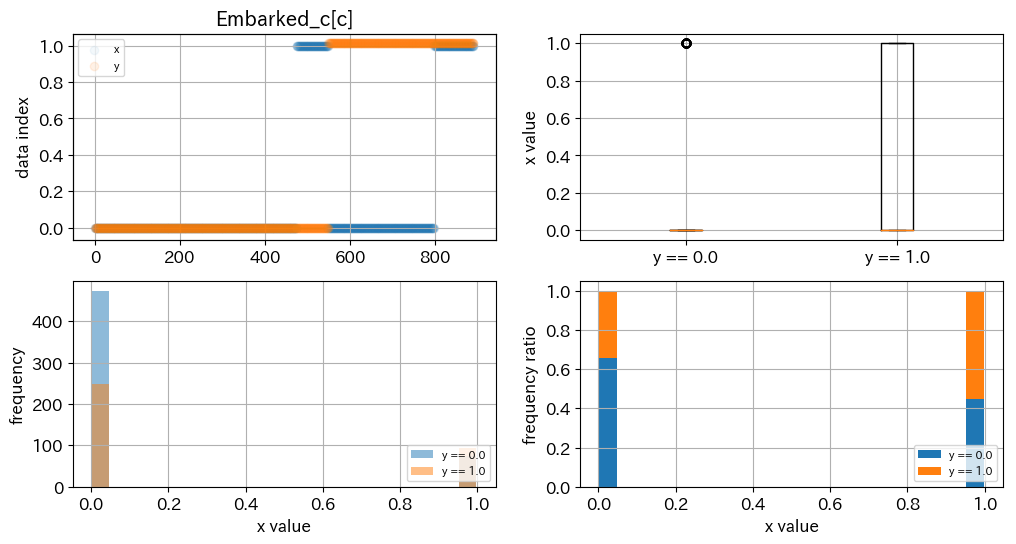



---------------------------------------------
[122]


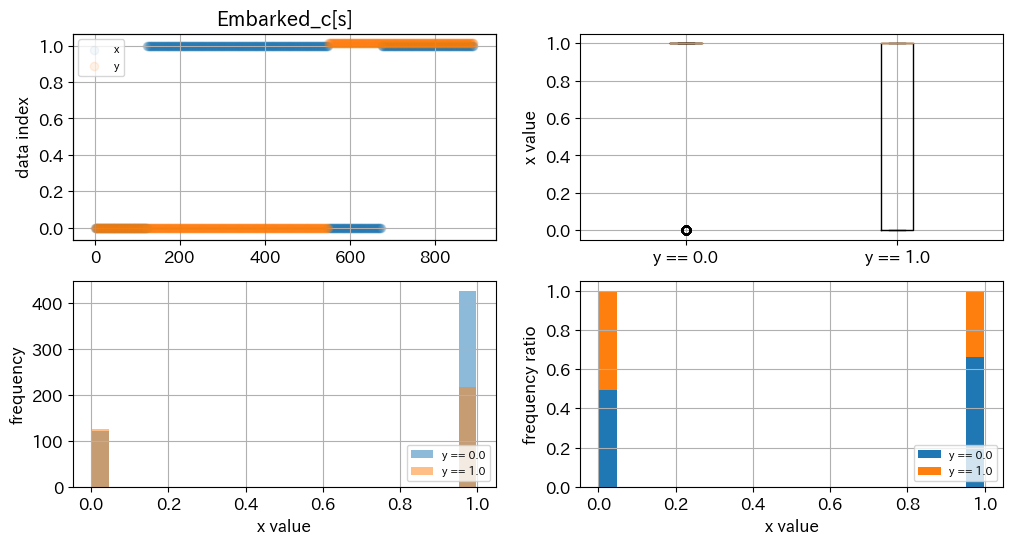



---------------------------------------------
[62]


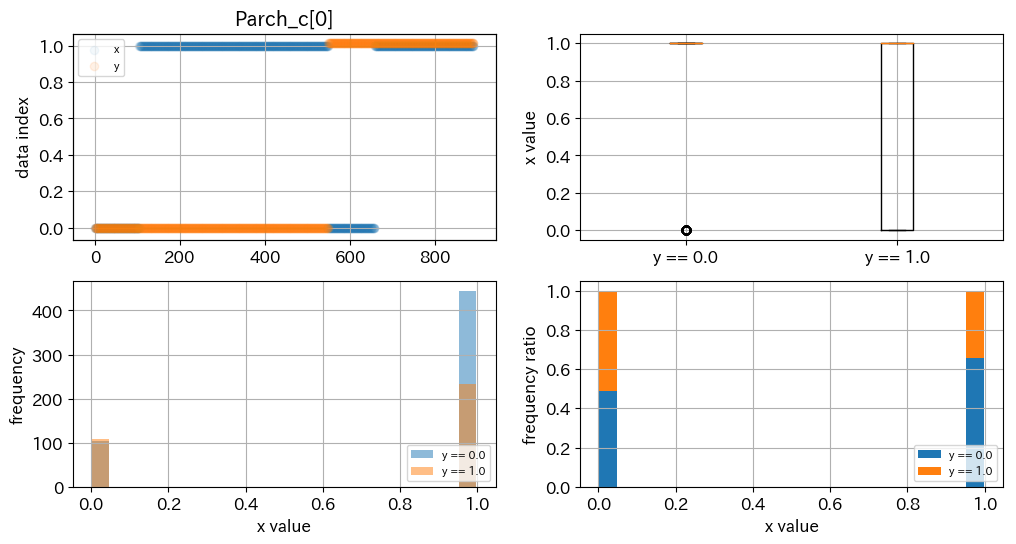



---------------------------------------------
[74]


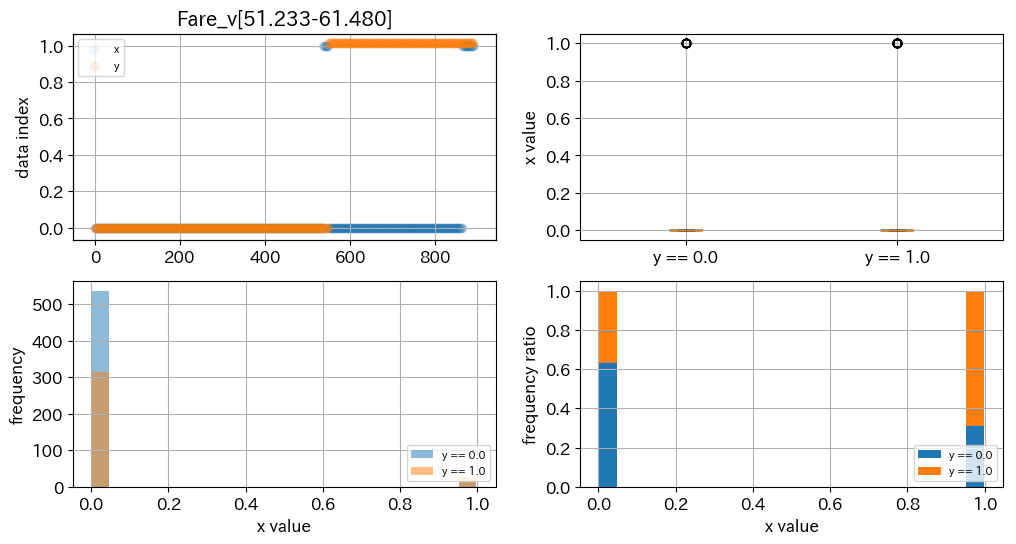



---------------------------------------------
[63]


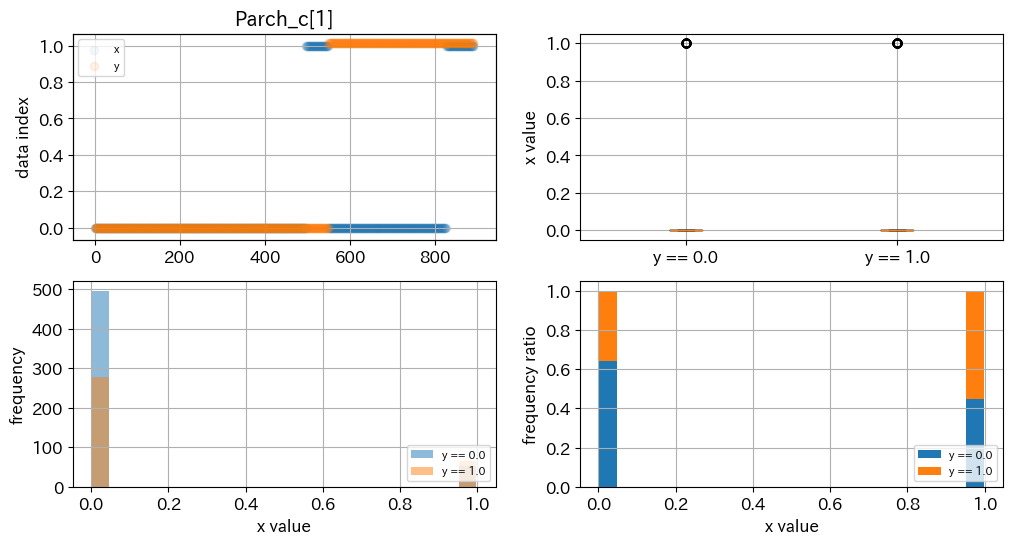



Total data num    :    891件
Positive data num :    342件 (38.38%)
Negative data num :    549件 (61.62%)


leakage check


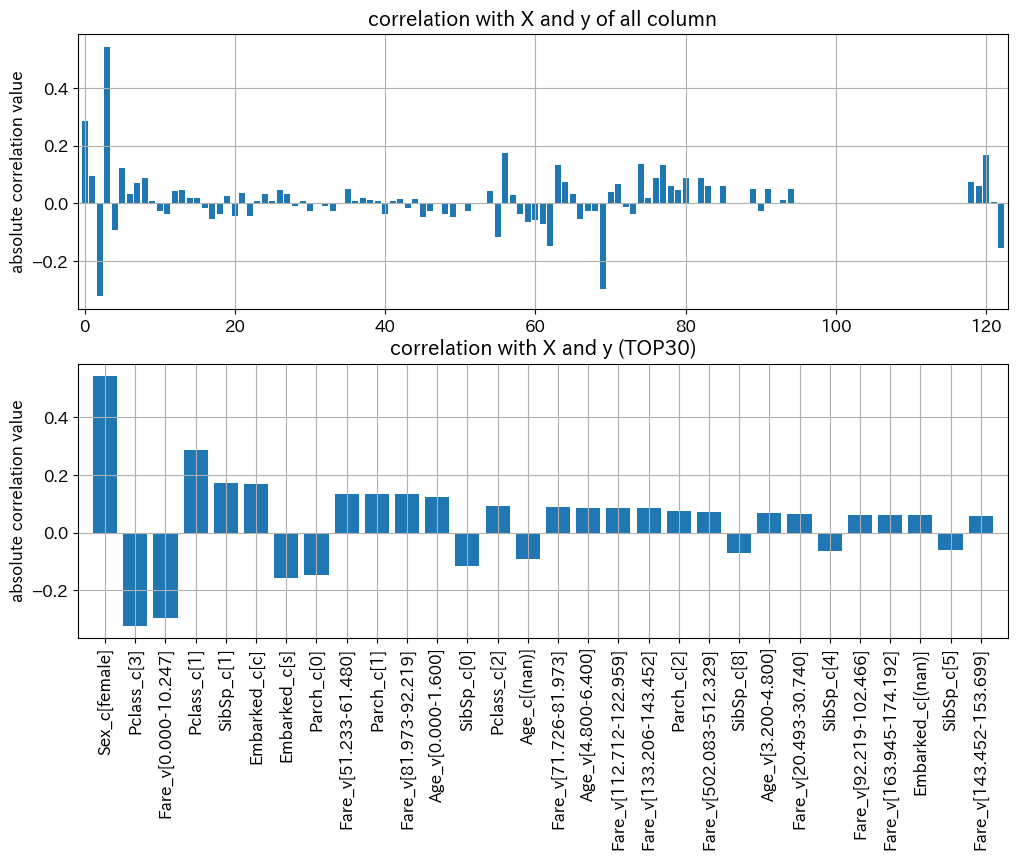

In [15]:
# [STEP 9]
# check leakage
corr_with_y = ppap_tab_utl.check_X_and_y_status(X           = X, 
                                                y           = y, 
                                                column_name = column_name)

_ = ppap_tab_utl.check_X_and_y_status(X           = X, 
                                      y           = y, 
                                      column_name = column_name, 
                                      abs_flg     = False, 
                                      cross_plot  = False)


2dim visualization


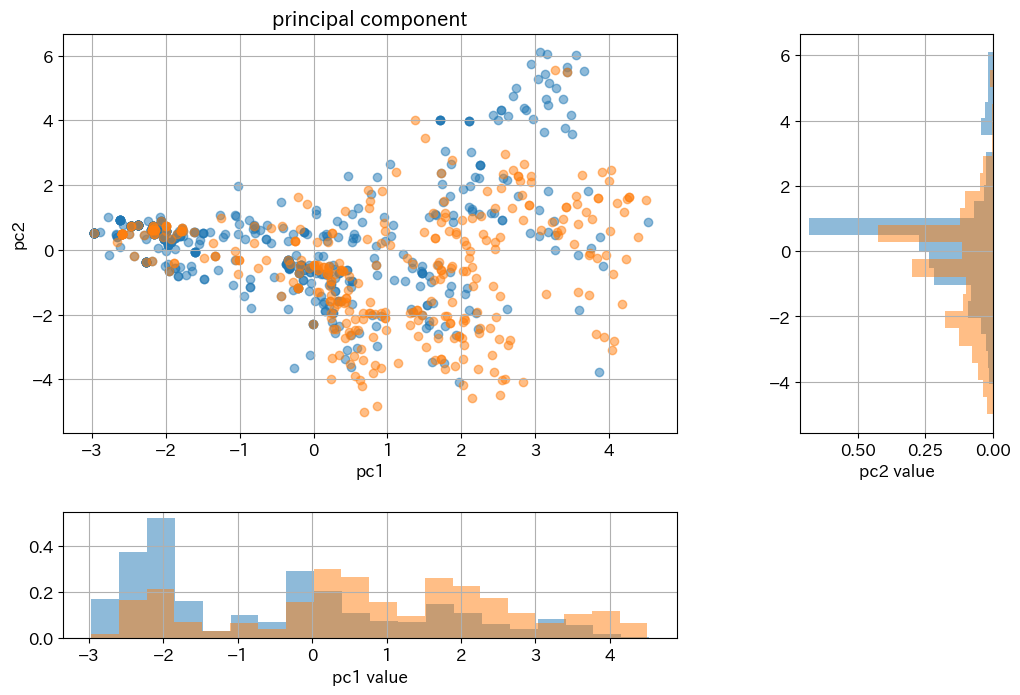

2dim visualization


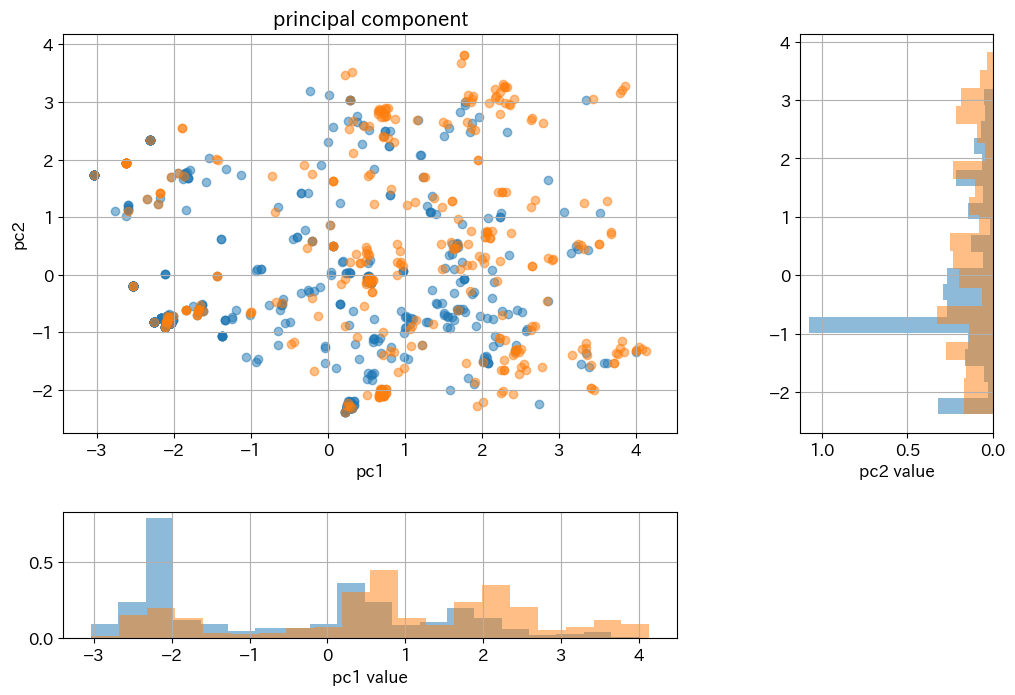

In [16]:
# [STEP 10-1]
# visualize on PCA
_, _, _ = ppap_tab_utl.understandable_visualize(X = X, 
                                                y = y)

# visualize on PCA (suppress outlier)
_, _, _ = ppap_tab_utl.understandable_visualize(X              = X, 
                                                y              = y, 
                                                X_outlier_care = True)


2dim visualization


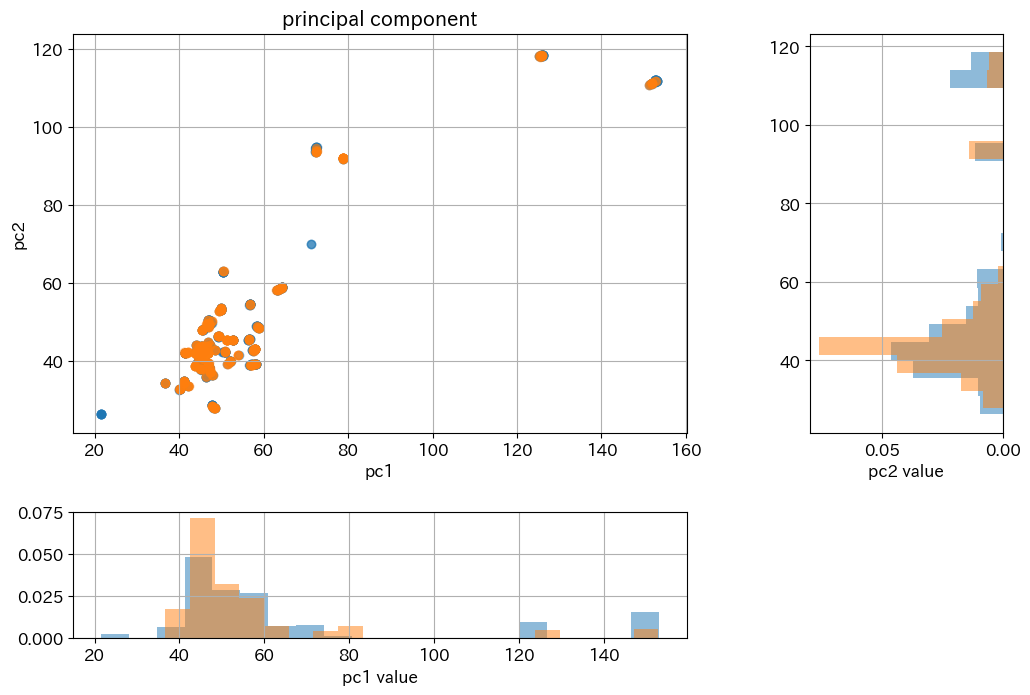

2dim visualization


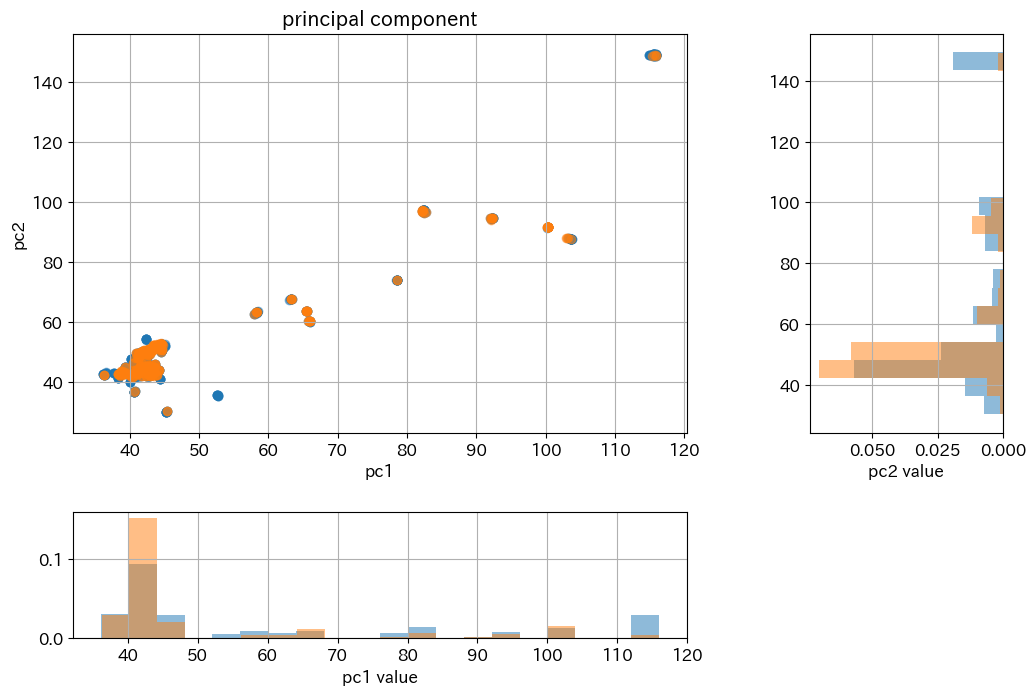

In [17]:
# [STEP 10-2]
# visualize on UMAP
_, _, _ = ppap_tab_utl.understandable_visualize(X     = X, 
                                                y     = y, 
                                                model = UMAP(random_state=0))

# visualize on UMAP (suppress outlier)
_, _, _ = ppap_tab_utl.understandable_visualize(X              = X, 
                                                y              = y,
                                                model          = UMAP(random_state=0),
                                                X_outlier_care = True)


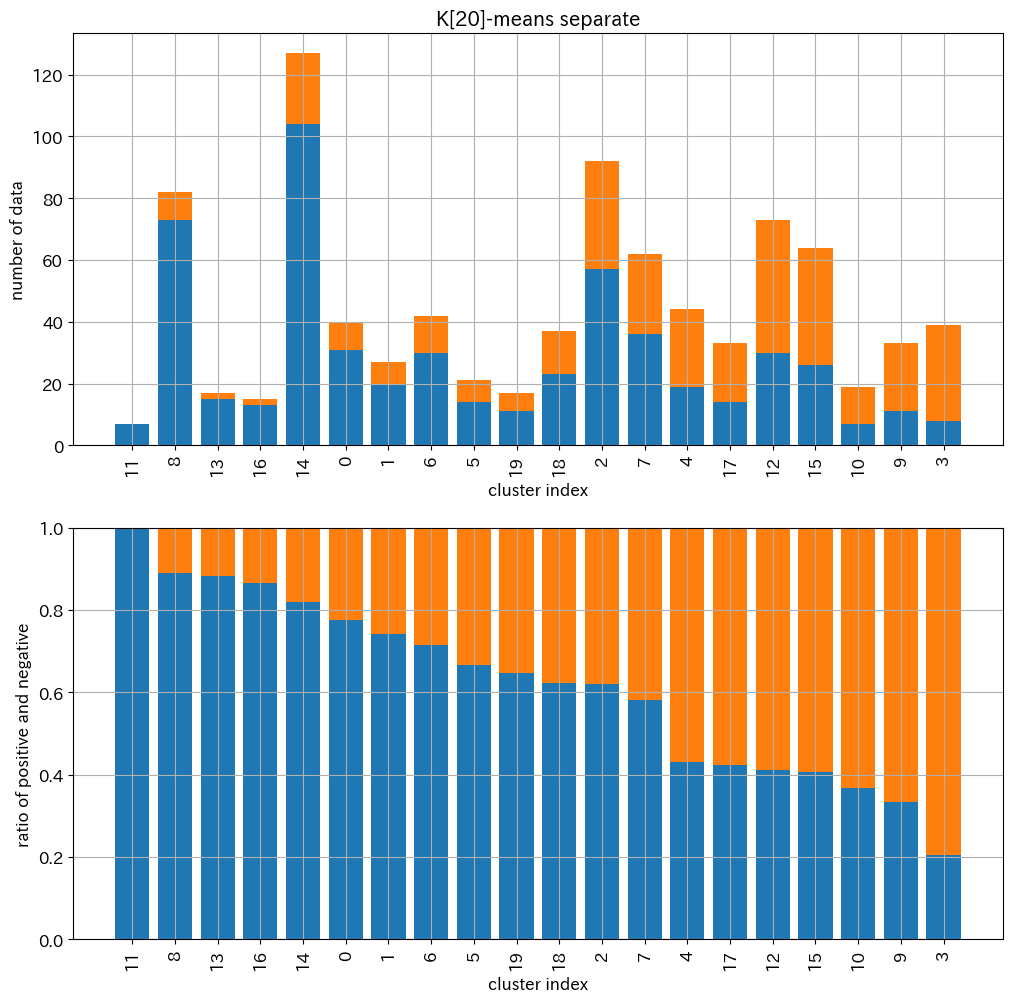

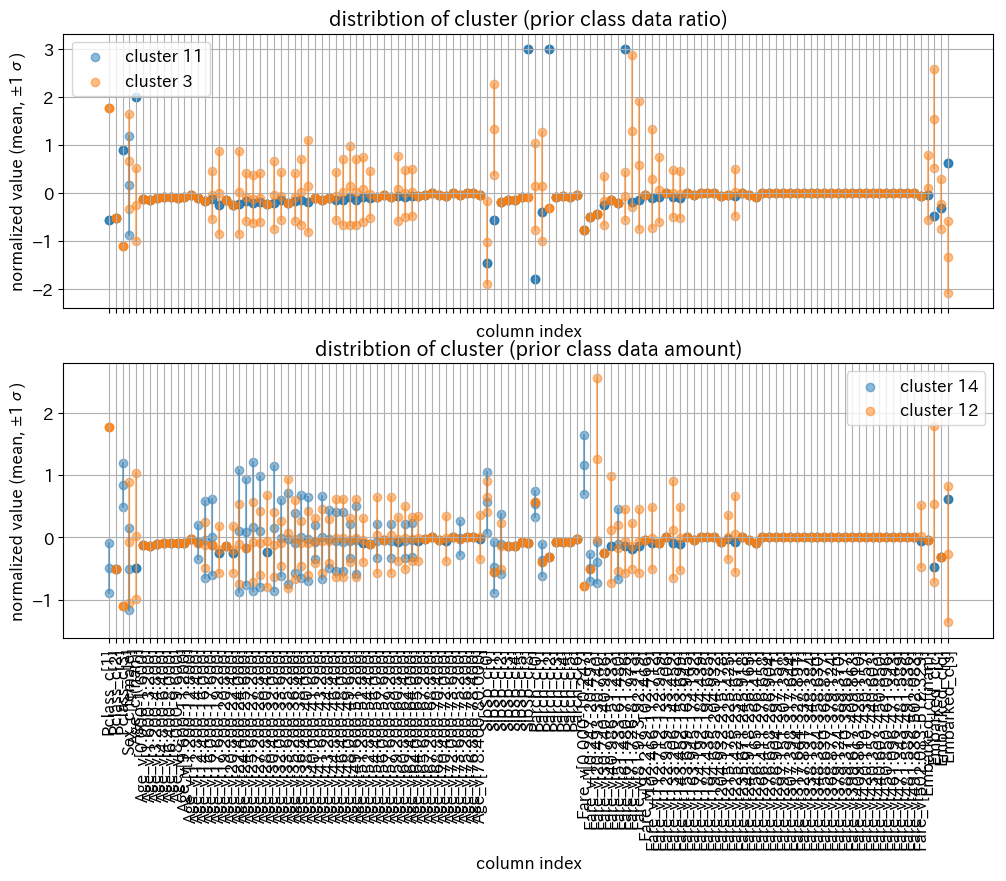

In [18]:
# [STEP 11] 
# judge predictable or not by kmeans
(kmeans_result, 
 _, 
 idx_sort_k) = ppap_tab_utl.kmeans_classification(X              = X, 
                                                  y              = y, 
                                                  column_name    = column_name, 
                                                  k              = 20, 
                                                  X_outlier_care = True)


k-nn searching on positive data [start time is 2019-07-10 13:51:24.911349]
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
                                [end time is 2019-07-10 13:51:26.454585]



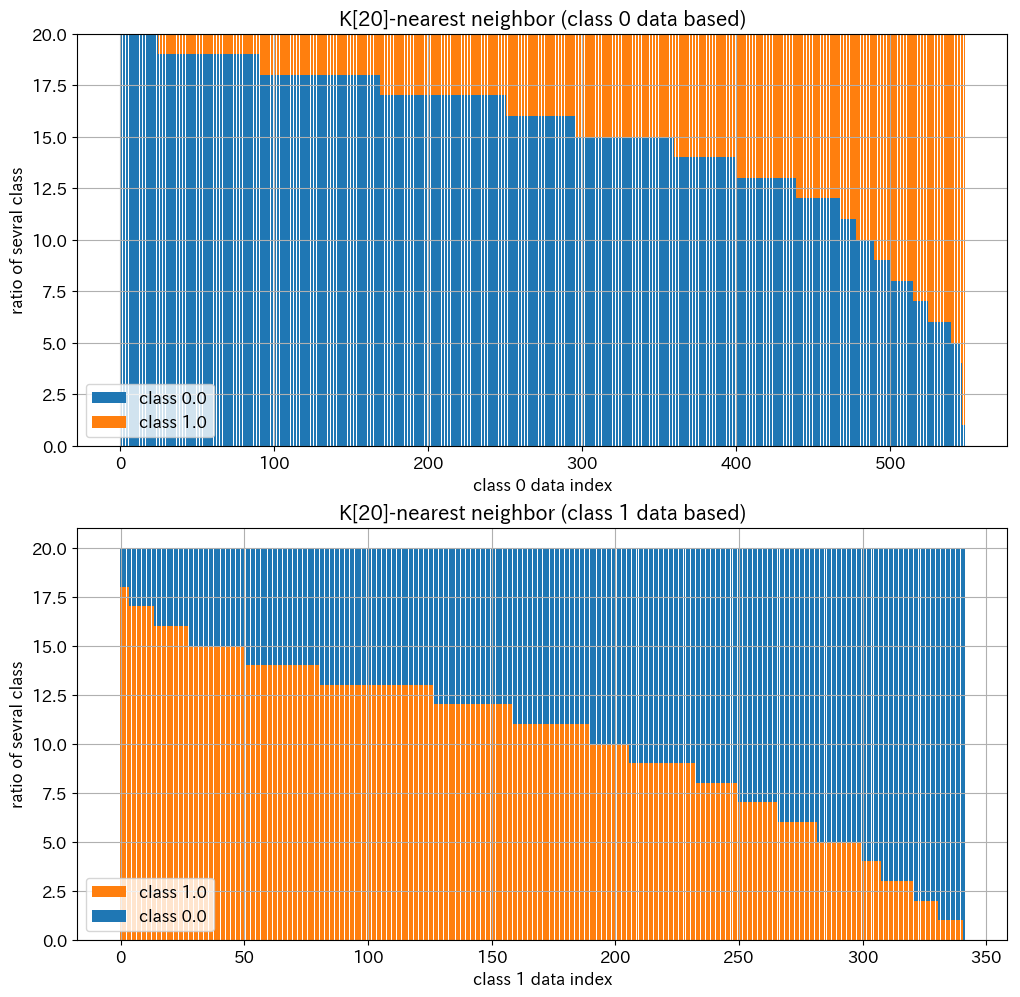

In [19]:
# [STEP 12-1] 
# judge predictable or not by knn
_ = ppap_tab_utl.knn_classification(X              = X, 
                                    y              = y, 
                                    X_outlier_care = True)


k-nn searching on positive data [start time is 2019-07-10 13:51:28.878387]
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
                                [end time is 2019-07-10 13:51:29.040936]



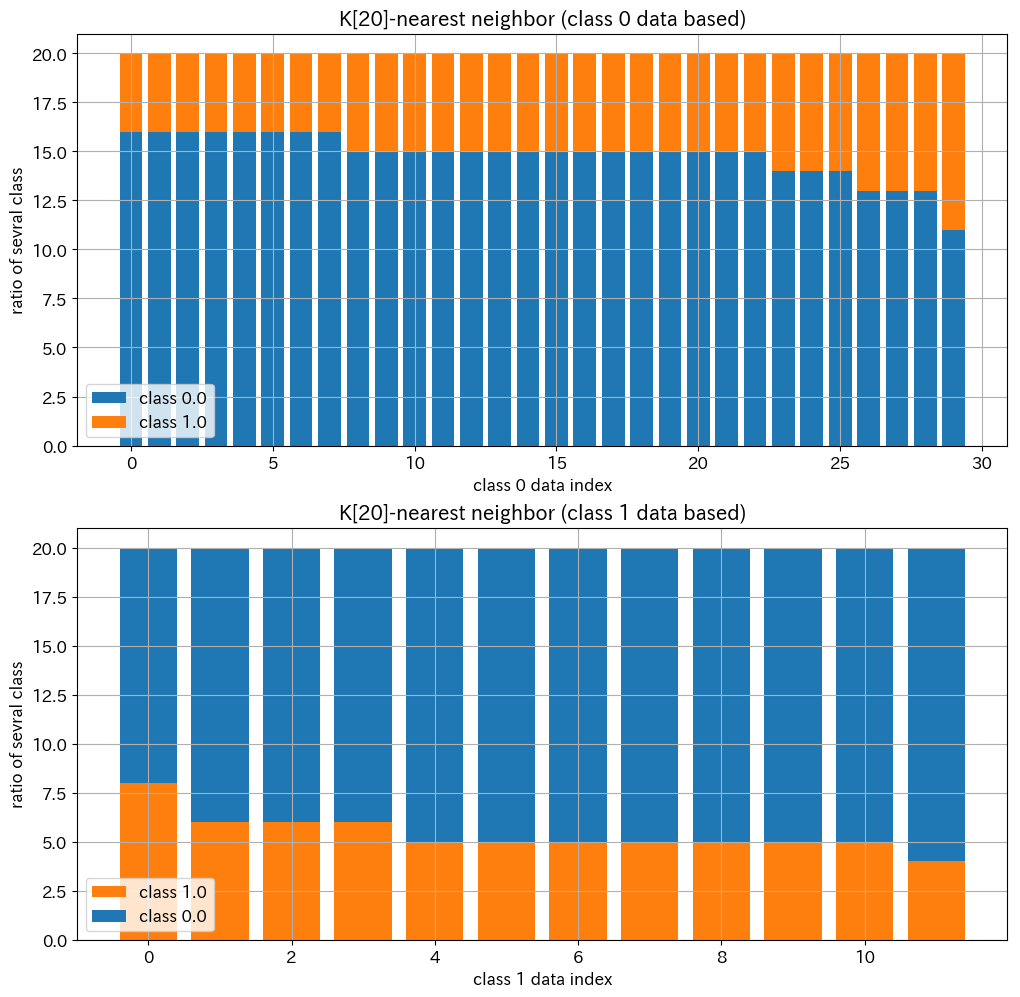

In [20]:
# [STEP 12-2] 
# judge predictable or not by knn
_ = ppap_tab_utl.knn_classification(X              = X[kmeans_result.labels_ == idx_sort_k[7]], 
                                    y              = y[kmeans_result.labels_ == idx_sort_k[7]], 
                                    X_outlier_care = True)


# learning

In [21]:
# separate train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
print('np.shape(X_train) = (%d, %d)' % np.shape(X_train))
print('np.shape(y_train) = (%d)'     % np.shape(y_train))
print('np.shape(X_test)  = (%d, %d)' % np.shape(X_test))
print('np.shape(y_test)  = (%d)'     % np.shape(y_test))


np.shape(X_train) = (445, 123)
np.shape(y_train) = (445)
np.shape(X_test)  = (446, 123)
np.shape(y_test)  = (446)


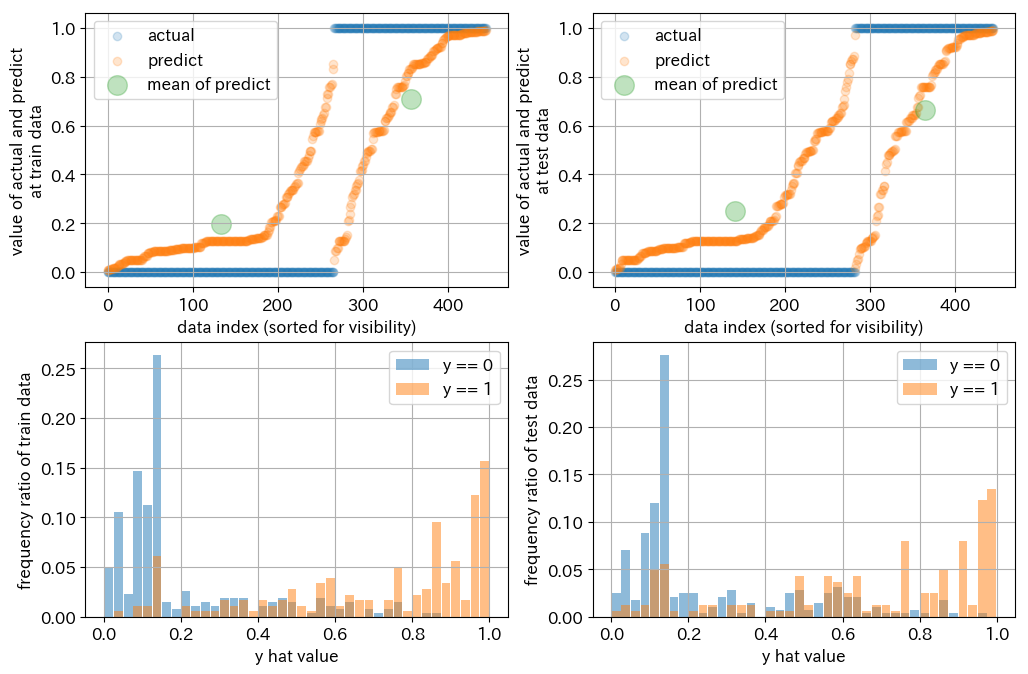

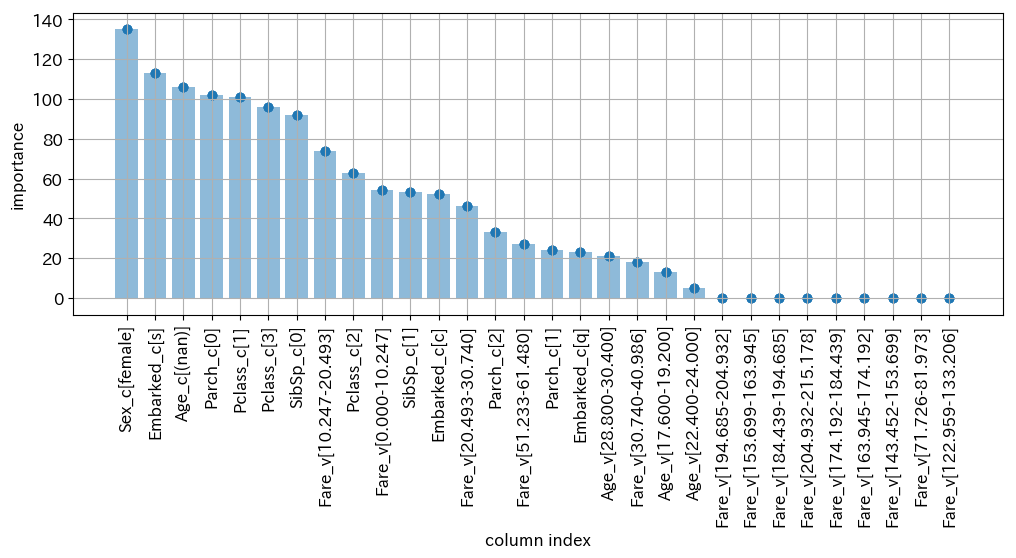

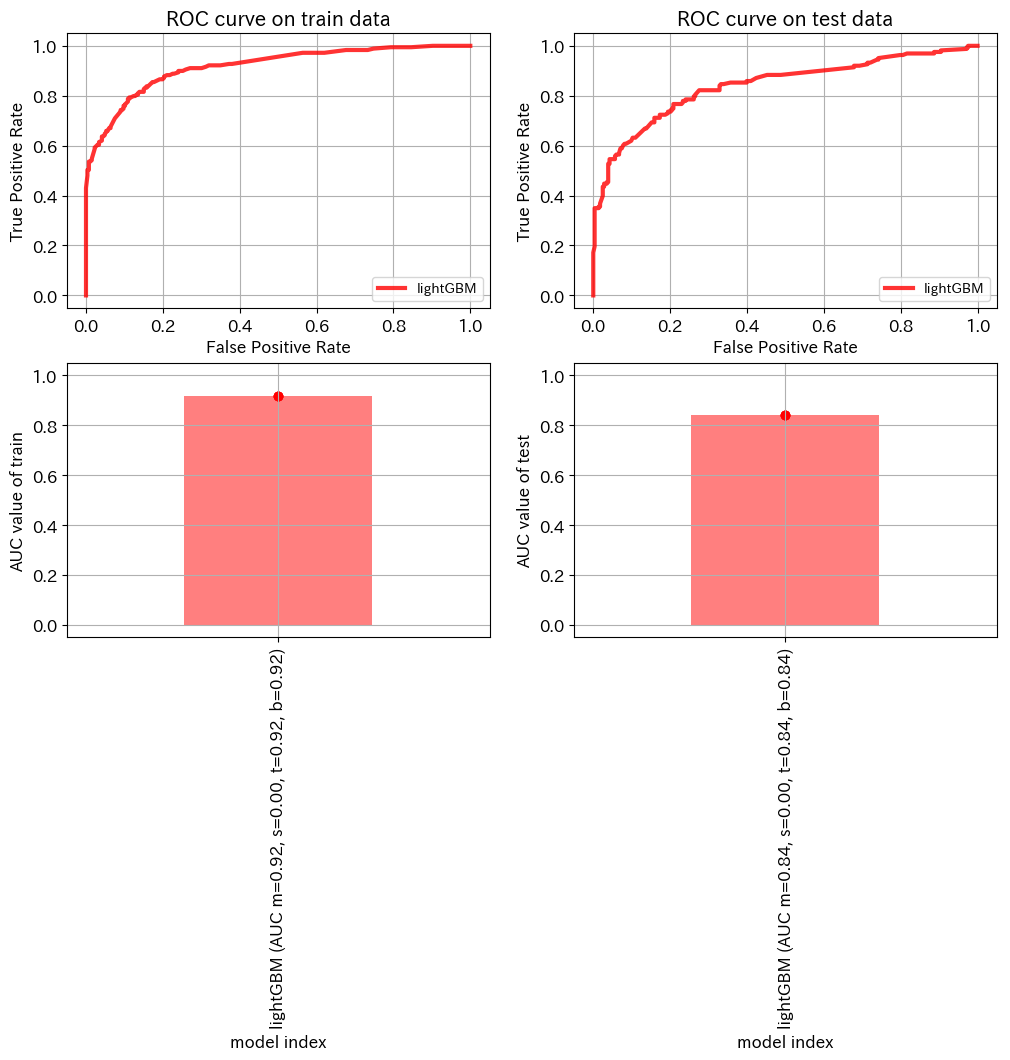

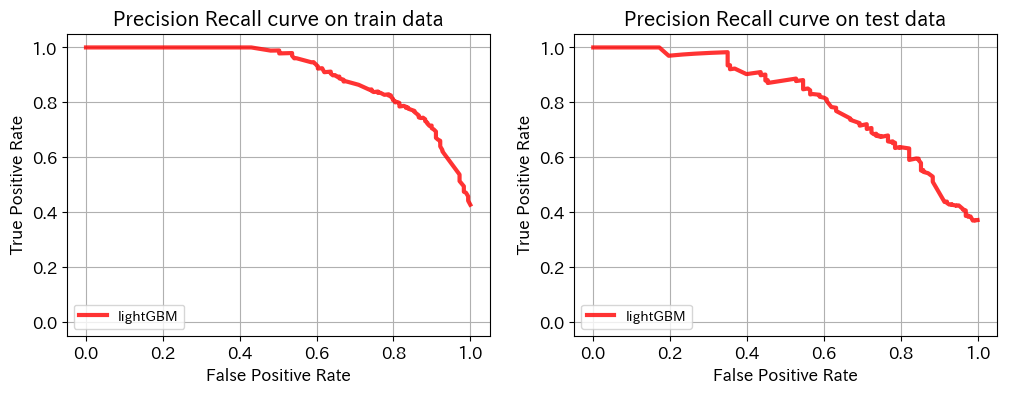

In [22]:
# [STEP 1]
# train and predict by one model 
model = LGBMClassifier(objective     = 'binary',  
                       learning_rate = 0.1, 
                       n_estimators  = 100, 
                       random_state  = 0, 
                       n_jobs        = 4) 

# exec
(model, 
 y_train_hat, 
 y_test_hat, 
 X_train_up, 
 y_train_up) = ppap_tab_cls.train_predict_and_measure(X_train        = X_train,
                                                      y_train        = y_train,
                                                      X_test         = X_test,
                                                      y_test         = y_test, 
                                                      model          = model, 
                                                      column_name    = column_name, 
                                                      alpha          = 0.2)


train on cv (model:[m:0,r:0] lightGBM(l:0.10,n:100)_RFE123, feature dim:123) [start time is 2019-07-10 13:51:31.938052]
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
AUC mean on train = 0.91, test = 0.84 [end time is 2019-07-10 13:51:33.550873]


train on cv (model:[m:1,r:0] lightGBM(l:0.10,n:100)_RFE123, feature dim:123) [start time is 2019-07-10 13:51:33.552459]
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
AUC mean on train = 0.89, test = 0.84 [end time is 2019-07-10 13:51:34.587091]


train on cv (model:[m:2,r:0] lightGBM(l:0.10,n:100)_RFE123, feature dim:123) [start time is 2019-07-10 13:51:34.589092]
--------------------------------------------------
START              

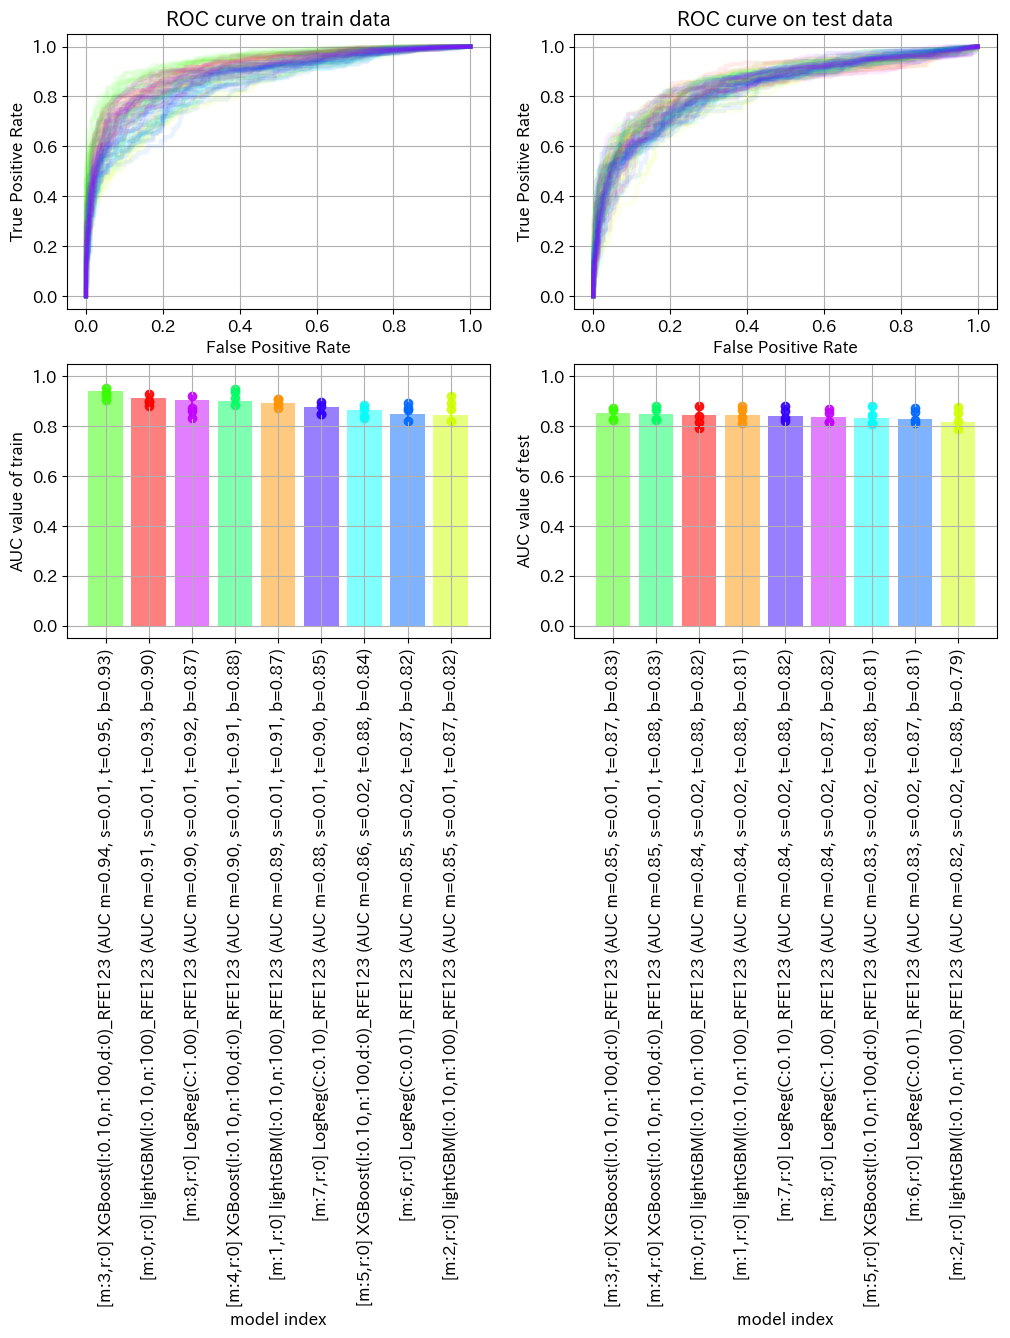

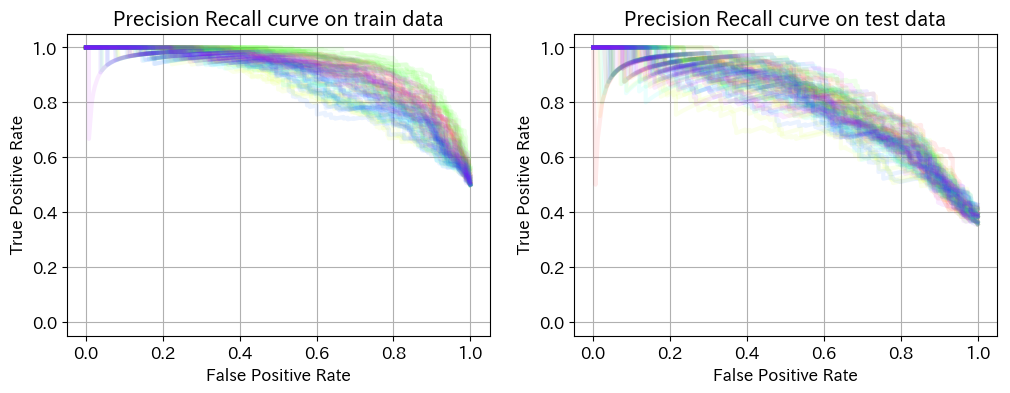

In [23]:
# [STEP 2]
# cross validation by multi model and rfe
model      = []
model_name = []

# set common param
# rfe_step   = [800, 600, 400, 200, 100, 50, 30, 20, 15, 10, 5]
rfe_step   = []

# 1. lightGBM
param = [[0.1, 100, 0.1, 20, 0.5, 2.0], 
         [0.1, 100, 0.3, 15, 0.3, 4.0], 
         [0.1, 100, 0.5, 10, 0.1, 6.0]]
for param_i in range(len(param)):
    model_tmp = LGBMClassifier(objective        = 'binary',  
                               learning_rate    = param[param_i][0], 
                               n_estimators     = param[param_i][1], 
                               min_child_weight = param[param_i][2],
                               num_leaves       = param[param_i][3],
                               colsample_bytree = param[param_i][4],
                               reg_lambda       = param[param_i][5],
                               subsample        = 0.3, 
                               random_state     = 0, 
                               n_jobs           = 4) 
    model.append(model_tmp)
    model_name.append('lightGBM(l:%.2f,n:%d)' % (param[param_i][0], param[param_i][1]))

# 2. XGBoost
param = [[0.1, 100, 0.1, 5, 0.5, 2.0], 
         [0.1, 100, 0.3, 4, 0.3, 4.0], 
         [0.1, 100, 0.5, 3, 0.1, 6.0]]
for param_i in range(len(param)):
    model_tmp = XGBClassifier(learning_rate    = param[param_i][0], 
                              n_estimators     = param[param_i][1], 
                              min_child_weight = param[param_i][2],
                              max_depth        = param[param_i][3],
                              colsample_bytree = param[param_i][4],
                              reg_lambda       = param[param_i][5],
                              subsample        = 0.3, 
                              random_state     = 0, 
                              n_jobs           = 4) 
    model.append(model_tmp)
    model_name.append('XGBoost(l:%.2f,n:%d,d:%d)' % (param[param_i][0], param[param_i][1], param[param_i][2]))

# 3. LogisticRegression
param = [[0.01], 
         [0.1], 
         [1.0]]
for param_i in range(len(param)):
    model_tmp = LogisticRegression(C      = param[param_i][0],
                                   solver = 'sag', 
                                   n_jobs = 4)
    model.append(model_tmp)
    model_name.append('LogReg(C:%.2f)' % (param[param_i][0]))

# exec
(importance_stock, 
 rfe_step, 
 remain_idx, 
 model_name_stock, 
 idx_sort_auc_test) = ppap_tab_cls.rfe_and_cv(X              = X, 
                                              y              = y, 
                                              model          = model, 
                                              model_name     = model_name, 
                                              column_name    = column_name,
                                              sample_balance = True, 
                                              rfe_step       = rfe_step, 
                                              draw_cv_ratio  = 0.0)

plt.show()


model is ...
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=0.1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=2.0, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.3)

use feature is ...
  - Sex_c[female] : 0.05
  - SibSp_c[0] : 0.03
  - Pclass_c[2] : 0.03
  - Pclass_c[3] : 0.03
  - Pclass_c[1] : 0.03
  - Age_c[(nan)] : 0.03
  - Age_v[30.400-32.000] : 0.03
  - Fare_v[0.000-10.247] : 0.03
  - Parch_c[0] : 0.03
  - Fare_v[10.247-20.493] : 0.03
  - Fare_v[20.493-30.740] : 0.03
  - SibSp_c[1] : 0.03
  - Embarked_c[s] : 0.03
  - Embarked_c[c] : 0.03
  - Age_v[25.600-27.200] : 0.02
  - Embarked_c[q] : 0.02
  - Parch_c[1] : 0.02
  - Age_v[17.600-19.200] : 0.02
  - Age_v[28.800-30.400] : 0.02
  - Parch_c[2] : 0.02
  - Age_v[0.000-1.600] : 0.02
  - Age_v[22

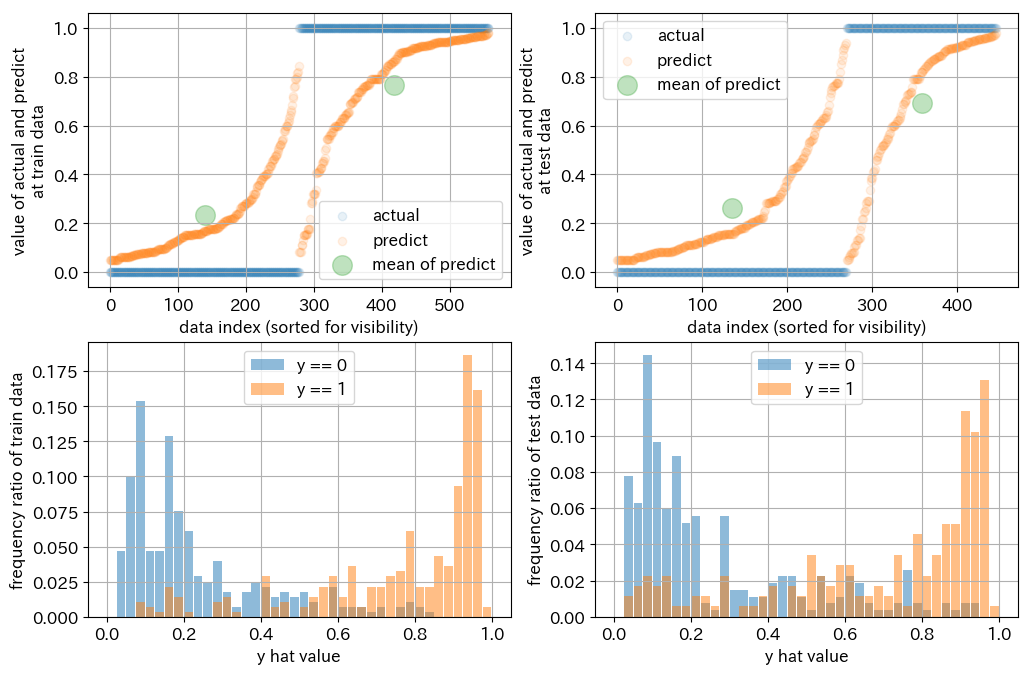

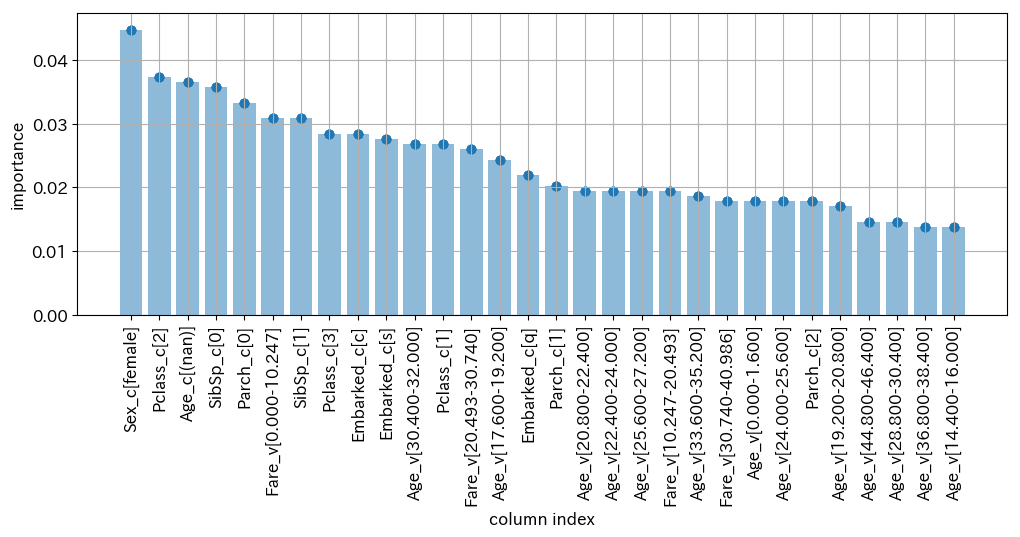



summary result


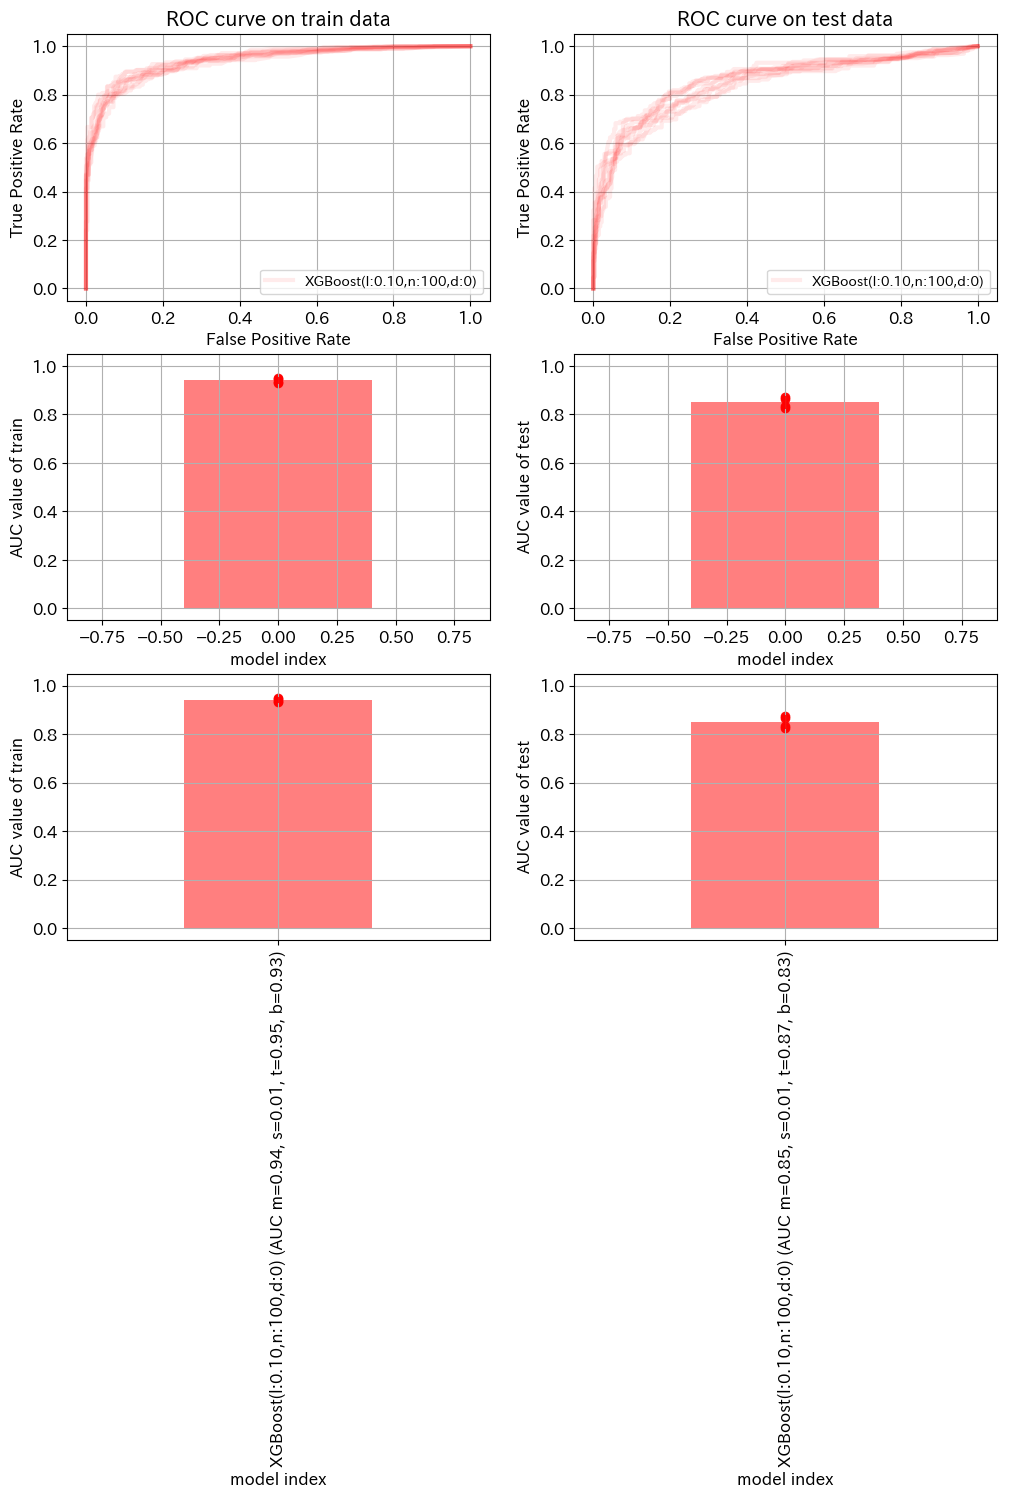

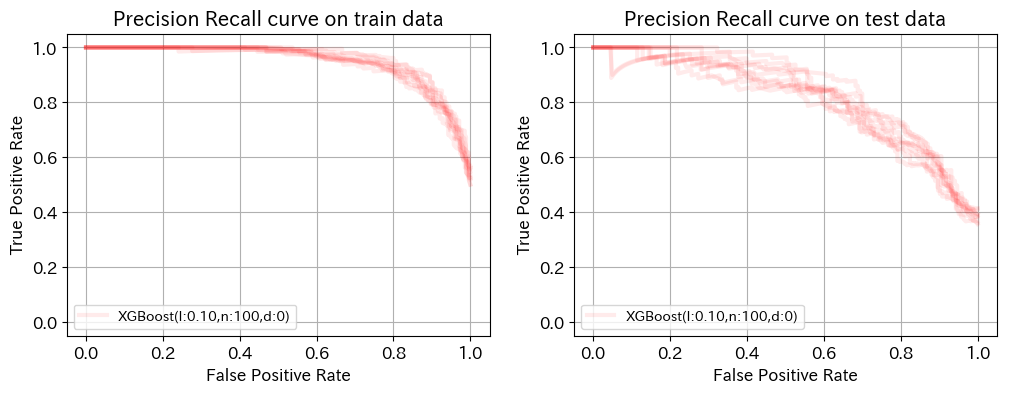

In [24]:
# [STEP 3]
# do the learning by good param setting 
rank_i       = 0 # choise method that column is small 

# 
model_i      = int(np.floor(idx_sort_auc_test[rank_i] / len(rfe_step)))
model_name_i = idx_sort_auc_test[rank_i]
rfe_step_i   = int(idx_sort_auc_test[rank_i] % len(rfe_step))

# 
model_       = model[model_i]
model_name_  = model_name_stock[idx_sort_auc_test[rank_i]]
model_name_  = model_name_[(model_name_.find('] ') + 2):]
model_name_  = model_name_[:model_name_.find('_RFE')]

# 
remain_idx_  = remain_idx[:, model_i, rfe_step_i]
X_slim       = X[:, remain_idx_]
column_name_ = column_name[remain_idx_]

# 
importance_  = np.mean(importance_stock[:, :, model_i, rfe_step_i], axis=1)

# 
print('model is ...')
print(model_)
print('')
print('use feature is ...')
for column_i in np.argsort(-importance_):
    if (remain_idx_[column_i]):
        print('  - %s : %.2f' % (column_name[column_i], importance_[column_i]))
print('')

# exec
(_, _, _, _, _) = ppap_tab_cls.cv_random(X              = X_slim, 
                                         y              = y, 
                                         model          = model_, 
                                         model_name     = model_name_, 
                                         column_name    = column_name_,
                                         sample_balance = True)


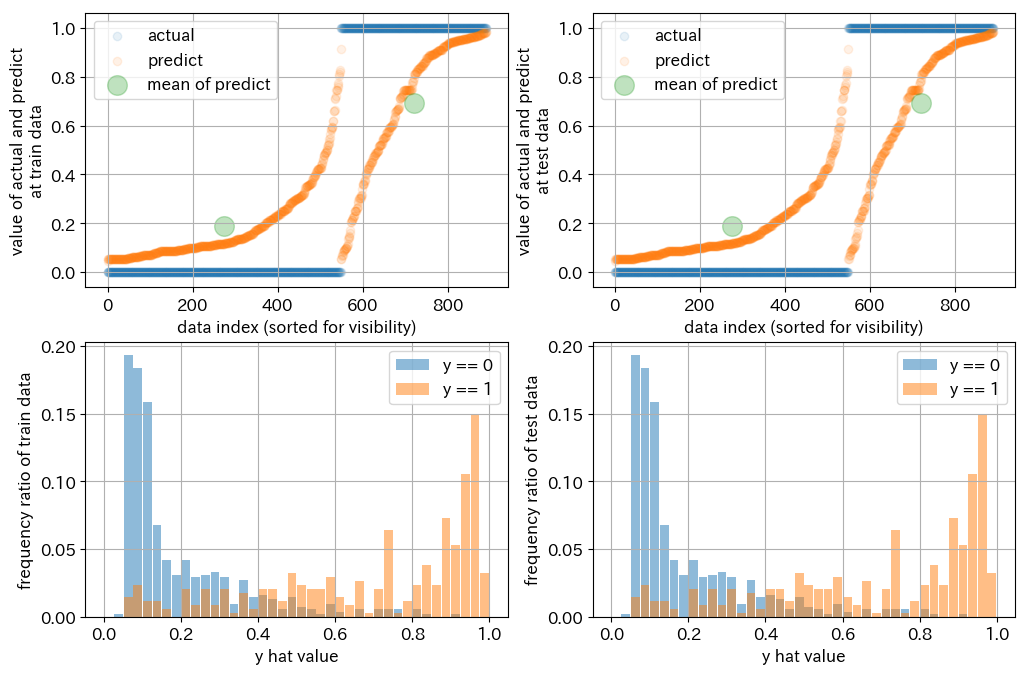

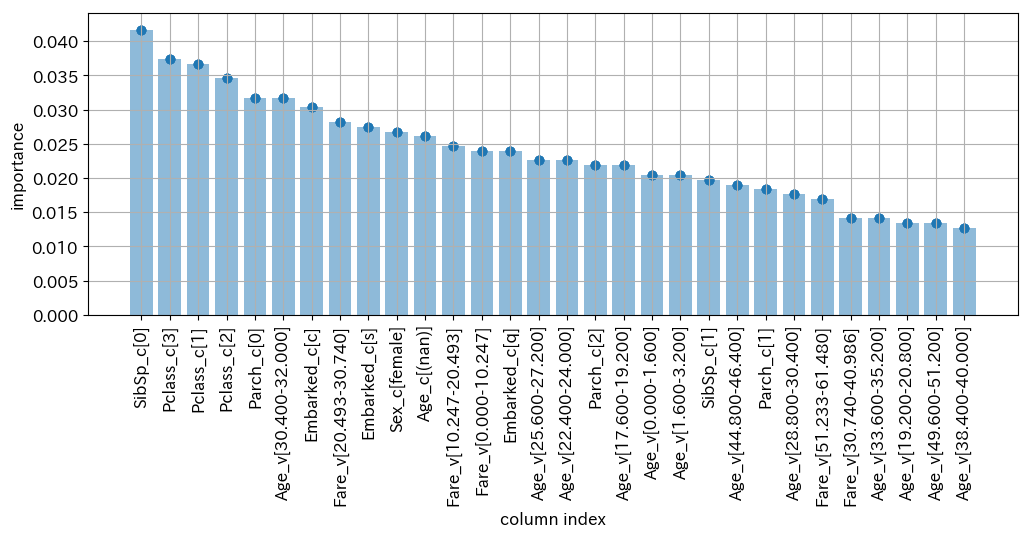

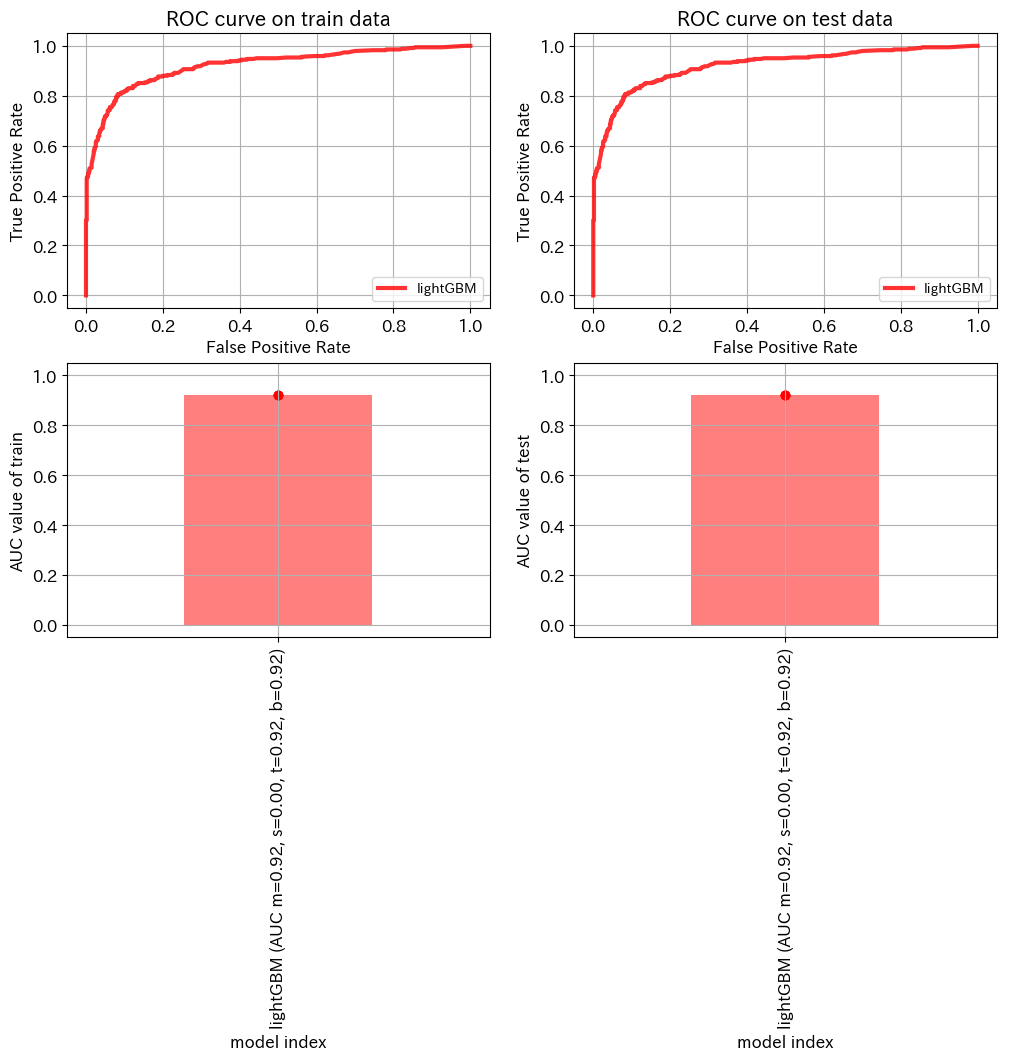

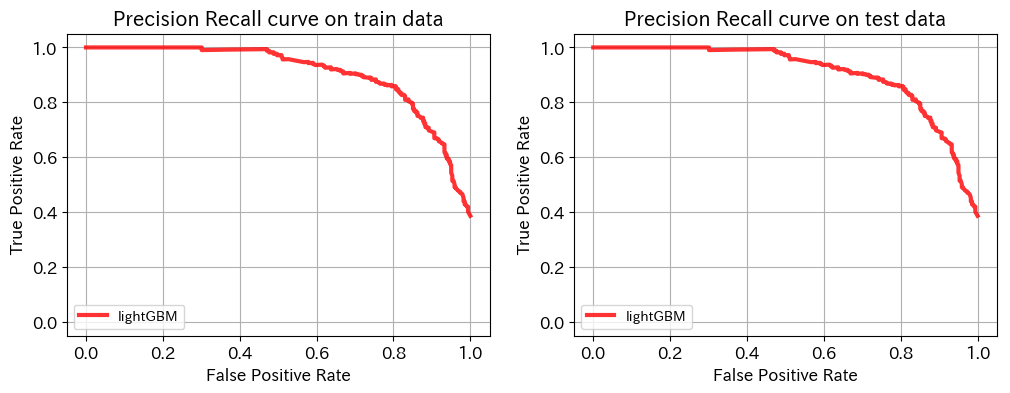

In [25]:
# [Step 4-1]
# try discretization for check wrong data
X_slim           = X[:, remain_idx_]
column_name_slim = column_name[remain_idx_]

# separate train data and test data
(X_train_slim, X_test_slim, 
 y_train, y_test) = train_test_split(X_slim, y, test_size=0.5, random_state=0)

# # exec
# (learned_model, 
#  y_train_hat, 
#  y_test_hat, 
#  X_train_up, 
#  y_train_up) = ppap_tab_cls.train_predict_and_measure(X_train        = X_train_slim,
#                                                      y_train        = y_train,
#                                                      X_test         = X_test_slim,
#                                                      y_test         = y_test, 
#                                                      model          = model_, 
#                                                      column_name    = column_name, 
#                                                      sample_balance = True)

# exec
(learned_model, 
 y_train_hat, 
 y_test_hat, 
 X_train_up, 
 y_train_up) = ppap_tab_cls.train_predict_and_measure(X_train        = X_slim,
                                                      y_train        = y,
                                                      X_test         = X_slim,
                                                      y_test         = y, 
                                                      model          = model_, 
                                                      column_name    = column_name, 
                                                      sample_balance = False)


In [26]:
# [Step 4-2]
# search large mistake

# # knn search
# (nearest_info) = ppap_tab_utl.knn_mistake_search(X           = X_test_slim, 
#                                                 y           = y_test, 
#                                                 y_hat       = y_test_hat, 
#                                                 column_name = column_name_slim, 
#                                                 k           = 50, 
#                                                 X_normalize = False)

# knn search
(nearest_info) = ppap_tab_utl.knn_mistake_search(X           = X_slim, 
                                                 y           = y, 
                                                 y_hat       = y_test_hat, 
                                                 column_name = column_name_slim, 
                                                 k           = 50, 
                                                 X_normalize = False)

# view
nearest_info[0].T


data index distance correct label         prediction    mistake  \
base              444        0             1  0:0.913, 1:0.087,   0.947697   
neighbor1         563        0             0  0:0.030, 1:0.970,  0.0523025   
neighbor2         470        0             0  0:0.334, 1:0.666,  0.0523025   
neighbor3         107        0             1  0:0.044, 1:0.956,   0.947697   
neighbor4         464        0             0  0:0.923, 1:0.077,  0.0523025   
neighbor5         101        0             0  0:0.893, 1:0.107,  0.0523025   
neighbor6         837        0             0  0:0.742, 1:0.258,  0.0523025   
neighbor7         611        0             0  0:0.880, 1:0.120,  0.0523025   
neighbor8         335        0             0  0:0.425, 1:0.575,  0.0523025   
neighbor9         454        0             0  0:0.091, 1:0.909,  0.0523025   
neighbor10        601        0             0  0:0.272, 1:0.728,  0.0523025   
neighbor11         29        0             0  0:0.047, 1:0.953,  0.0523025   
neighbor12        121        0             0  0:0.915, 1:0.085,  0.0523025   
neighbor13         95        0             0  0:0.893, 1:0.107,  0.0523025   
neighbor14         45        0             0  0:0.558, 1:0.442,  0.0523025   
neighbor15        250        0             0  0:0.122, 1:0.878,  0.0523025   
neighbor16        589        0             0  0:0.834, 1:0.166,  0.0523025   
neighbor17        384        0             0  0:0.859, 1:0.141,  0.0523025   
neighbor18        158        0             0  0:0.606, 1:0.394,  0.0523025   
neighbor19        511        0             0  0:0.253, 1:0.747,  0.0523025   
neighbor20        650        0             0  0:0.823, 1:0.177,  0.0523025   
neighbor21        739        0             0  0:0.828, 1:0.172,  0.0523025   
neighbor22         87        0             0  0:0.190, 1:0.810,  0.0523025   
neighbor23         77        0             0  0:0.695, 1:0.305,  0.0523025   
neighbor24        878        0             0  0:0.846, 1:0.154,  0.0523025   
neighbor25        656        0             0  0:0.734, 1:0.266,  0.0523025   
neighbor26         76        0             0  0:0.883, 1:0.117,  0.0523025   
neighbor27        154        0             0  0:0.755, 1:0.245,  0.0523025   
neighbor28        223        0             0  0:0.255, 1:0.745,  0.0523025   
neighbor29        738        0             0  0:0.948, 1:0.052,  0.0523025   
neighbor30        304        0             0  0:0.737, 1:0.263,  0.0523025   
neighbor31        868        0             0  0:0.047, 1:0.953,  0.0523025   
neighbor32        667        0             0  0:0.255, 1:0.745,  0.0523025   
neighbor33        648        0             0  0:0.884, 1:0.116,  0.0523025   
neighbor34        410        0             0  0:0.510, 1:0.490,  0.0523025   
neighbor35        425        0             0  0:0.520, 1:0.480,  0.0523025   
neighbor36        564        1             0  0:0.883, 1:0.117,   0.428055   
neighbor37        235        1             0  0:0.913, 1:0.087,   0.428055   
neighbor38        415        1             0  0:0.675, 1:0.325,   0.428055   
neighbor39        189        2             0  0:0.340, 1:0.660,  0.0699039   
neighbor40        561        2             0  0:0.647, 1:0.353,  0.0701845   
neighbor41        623        2             0  0:0.241, 1:0.759,  0.0869012   
neighbor42        552        2             0  0:0.883, 1:0.117,   0.106905   
neighbor43        538        2             0  0:0.098, 1:0.902,   0.101845   
neighbor44        196        2             0  0:0.404, 1:0.596,   0.106905   
neighbor45        531        2             0  0:0.948, 1:0.052,   0.116938   
neighbor46        528        2             0  0:0.825, 1:0.175,  0.0701845   
neighbor47        202        2             0  0:0.255, 1:0.745,  0.0768843   
neighbor48        204        2             1  0:0.809, 1:0.191,   0.902096   
neighbor49        524        2             0  0:0.649, 1:0.351,   0.116938   
neighbor50        522        2   

In [27]:
# 
pd.DataFrame(X_slim, columns=column_name_slim).describe()

# 
df_Xy.loc[[int(nearest_info[0].loc['data index', 'base']), 
           int(nearest_info[0].loc['data index', 'neighbor1']), 
           int(nearest_info[0].loc['data index', 'neighbor2']), 
           int(nearest_info[0].loc['data index', 'neighbor3']), 
           int(nearest_info[0].loc['data index', 'neighbor4']), 
           int(nearest_info[0].loc['data index', 'neighbor5']), 
           int(nearest_info[0].loc['data index', 'neighbor6']), 
           int(nearest_info[0].loc['data index', 'neighbor7']), 
           int(nearest_info[0].loc['data index', 'neighbor8']), 
           int(nearest_info[0].loc['data index', 'neighbor9']), 
           int(nearest_info[0].loc['data index', 'neighbor10']), 
           int(nearest_info[0].loc['data index', 'neighbor11']), 
           int(nearest_info[0].loc['data index', 'neighbor12']), 
           int(nearest_info[0].loc['data index', 'neighbor13']), 
           int(nearest_info[0].loc['data index', 'neighbor14']), 
           int(nearest_info[0].loc['data index', 'neighbor15']), 
           int(nearest_info[0].loc['data index', 'neighbor16']), 
           int(nearest_info[0].loc['data index', 'neighbor17']), 
           int(nearest_info[0].loc['data index', 'neighbor18']), 
           int(nearest_info[0].loc['data index', 'neighbor19']), 
           int(nearest_info[0].loc['data index', 'neighbor20']), 
           int(nearest_info[0].loc['data index', 'neighbor21']), 
           int(nearest_info[0].loc['data index', 'neighbor22']), 
           int(nearest_info[0].loc['data index', 'neighbor23']), 
           int(nearest_info[0].loc['data index', 'neighbor24']), 
           int(nearest_info[0].loc['data index', 'neighbor25']), 
           int(nearest_info[0].loc['data index', 'neighbor26']), 
           int(nearest_info[0].loc['data index', 'neighbor27']), 
           int(nearest_info[0].loc['data index', 'neighbor28']), 
           int(nearest_info[0].loc['data index', 'neighbor29']), 
           int(nearest_info[0].loc['data index', 'neighbor30']), 
           int(nearest_info[0].loc['data index', 'neighbor31']), 
           int(nearest_info[0].loc['data index', 'neighbor32']), 
           int(nearest_info[0].loc['data index', 'neighbor33']), 
           int(nearest_info[0].loc['data index', 'neighbor34']), 
           int(nearest_info[0].loc['data index', 'neighbor35'])], :]


PassengerId Survived Pclass                               Name   Sex  Age  \
444         445        1      3  Johannesen-Bratthammer, Mr. Bernt  male  NaN   
563         564        0      3                  Simmons, Mr. John  male  NaN   
470         471        0      3                  Keefe, Mr. Arthur  male  NaN   
107         108        1      3             Moss, Mr. Albert Johan  male  NaN   
464         465        0      3                 Maisner, Mr. Simon  male  NaN   
101         102        0      3   Petroff, Mr. Pastcho ("Pentcho")  male  NaN   
837         838        0      3                Sirota, Mr. Maurice  male  NaN   
611         612        0      3              Jardin, Mr. Jose Neto  male  NaN   
335         336        0      3                 Denkoff, Mr. Mitto  male  NaN   
454         455        0      3                Peduzzi, Mr. Joseph  male  NaN   
601         602        0      3               Slabenoff, Mr. Petco  male  NaN   
29           30        0      3                Todoroff, Mr. Lalio  male  NaN   
121         122        0      3         Moore, Mr. Leonard Charles  male  NaN   
95           96        0      3        Shorney, Mr. Charles Joseph  male  NaN   
45           46        0      3           Rogers, Mr. William John  male  NaN   
250         251        0      3             Reed, Mr. James George  male  NaN   
589         590        0      3                Murdlin, Mr. Joseph  male  NaN   
384         385        0      3             Plotcharsky, Mr. Vasil  male  NaN   
158         159        0      3                Smiljanic, Mr. Mile  male  NaN   
511         512        0      3                  Webber, Mr. James  male  NaN   
650         651        0      3                  Mitkoff, Mr. Mito  male  NaN   
739         740        0      3                 Nankoff, Mr. Minko  male  NaN   
87           88        0      3      Slocovski, Mr. Selman Francis  male  NaN   
77           78        0      3           Moutal, Mr. Rahamin Haim  male  NaN   
878         879        0      3                 Laleff, Mr. Kristo  male  NaN   
656         657        0      3              Radeff, Mr. Alexander  male  NaN   
76           77        0      3                  Staneff, Mr. Ivan  male  NaN   
154         155        0      3              Olsen, Mr. Ole Martin  male  NaN   
223         224        0      3               Nenkoff, Mr. Christo  male  NaN   
738         739        0      3                 Ivanoff, Mr. Kanio  male  NaN   
304         305        0      3  Williams, Mr. Howard Hugh "Harry"  male  NaN   
868         869        0      3        van Melkebeke, Mr. Philemon  male  NaN   
667         668        0      3         Rommetvedt, Mr. Knud Paust  male  NaN   
648         649        0      3                 Willey, Mr. Edward  male  NaN   
410         411        0      3                 Sdycoff, Mr. Todor  male  NaN   
425         426        0      3             Wiseman, Mr. Phillippe  male  NaN   

    SibSp Parch              Ticket    Fare Cabin Embarked  
444     0     0               65306  8.1125   NaN        S  
563     0     0     SOTON/OQ 392082    8.05   NaN        S  
470     0     0              323592    7.25   NaN        S  
107     0     0              312991   7.775   NaN        S  
464     0     0            A/S 2816    8.05   NaN        S  
101     0     0              349215  7.8958   NaN        S  
837     0     0              392092    8.05   NaN        S  
611     0     0  SOTON/O.Q. 3101305    7.05   NaN        S  
335     0     0              349225  7.8958   NaN        S  
454     0     0            A/5 2817    8.05   NaN        S  
601     0     0              349214  7.8958   NaN        S  
29      0     0              349216  7.8958   NaN        S  
121     0     0           A4. 54510    8.05   NaN        S  
95      0     0              374910    8.05   NaN        S  
45      0     0     S.C./A.4. 23567    8.05   NaN        S  
250     0     0              3

In [28]:
# view
nearest_info[2].T


data index distance correct label         prediction    mistake  \
base              414        0             1  0:0.913, 1:0.087,   0.934194   
neighbor1         603        0             0  0:0.030, 1:0.970,  0.0658058   
neighbor2         696        0             0  0:0.334, 1:0.666,  0.0658058   
neighbor3         606        2             0  0:0.044, 1:0.956,  0.0952492   
neighbor4         579        2             1  0:0.923, 1:0.077,   0.748238   
neighbor5         157        2             0  0:0.893, 1:0.107,  0.0952492   
neighbor6         158        2             0  0:0.742, 1:0.258,  0.0523025   
neighbor7         574        2             0  0:0.880, 1:0.120,  0.0893252   
neighbor8         569        2             1  0:0.425, 1:0.575,   0.748238   
neighbor9         162        2             0  0:0.091, 1:0.909,   0.212743   
neighbor10        163        2             0  0:0.272, 1:0.728,  0.0716333   
neighbor11        566        2             0  0:0.047, 1:0.953,  0.0979043   
neighbor12        563        2             0  0:0.915, 1:0.085,  0.0523025   
neighbor13        561        2             0  0:0.893, 1:0.107,  0.0701845   
neighbor14        173        2             0  0:0.558, 1:0.442,  0.0869012   
neighbor15        528        2             0  0:0.122, 1:0.878,  0.0701845   
neighbor16        179        2             0  0:0.834, 1:0.166,  0.0699039   
neighbor17        521        2             0  0:0.859, 1:0.141,  0.0869012   
neighbor18        519        2             0  0:0.606, 1:0.394,   0.251762   
neighbor19        514        2             0  0:0.253, 1:0.747,  0.0689013   
neighbor20        511        2             0  0:0.823, 1:0.177,  0.0523025   
neighbor21        189        2             0  0:0.828, 1:0.172,  0.0699039   
neighbor22        500        2             0  0:0.190, 1:0.810,  0.0716333   
neighbor23        499        2             0  0:0.695, 1:0.305,  0.0689013   
neighbor24        494        2             0  0:0.846, 1:0.154,  0.0869012   
neighbor25        491        2             0  0:0.734, 1:0.266,  0.0869012   
neighbor26        154        2             0  0:0.883, 1:0.117,  0.0523025   
neighbor27        152        2             0  0:0.755, 1:0.245,  0.0590128   
neighbor28        589        2             0  0:0.255, 1:0.745,  0.0523025   
neighbor29        488        2             0  0:0.948, 1:0.052,  0.0952492   
neighbor30        663        2             0  0:0.737, 1:0.263,  0.0699039   
neighbor31        656        2             0  0:0.047, 1:0.953,  0.0523025   
neighbor32        652        2             0  0:0.255, 1:0.745,  0.0869012   
neighbor33        650        2             0  0:0.884, 1:0.116,  0.0523025   
neighbor34        121        2             0  0:0.510, 1:0.490,  0.0523025   
neighbor35        648        2             0  0:0.520, 1:0.480,  0.0523025   
neighbor36        646        2             0  0:0.883, 1:0.117,  0.0979043   
neighbor37        640        2             0  0:0.913, 1:0.087,  0.0853096   
neighbor38        127        2             1  0:0.675, 1:0.325,   0.931099   
neighbor39        636        2             0  0:0.340, 1:0.660,   0.251762   
neighbor40        129        2             0  0:0.647, 1:0.353,  0.0828816   
neighbor41        588        2             0  0:0.241, 1:0.759,  0.0869012   
neighbor42        131        2             0  0:0.883, 1:0.117,  0.0853096   
neighbor43        628        2             0  0:0.098, 1:0.902,   0.212743   
neighbor44        623        2             0  0:0.404, 1:0.596,  0.0869012   
neighbor45        614        2             0  0:0.948, 1:0.052,  0.0768843   
neighbor46        138        2             0  0:0.825, 1:0.175,  0.0893252   
neighbor47        611        2             0  0:0.255, 1:0.745,  0.0523025   
neighbor48        283        2             1  0:0.809, 1:0.191,   0.902096   
neighbor49        601        2             0  0:0.649, 1:0.351,  0.0523025   
neighbor50        146        2   

In [29]:
# 
pd.DataFrame(X_slim, columns=column_name_slim).describe()

# 
df_Xy.loc[[int(nearest_info[2].loc['data index', 'base']), 
           int(nearest_info[2].loc['data index', 'neighbor1']), 
           int(nearest_info[2].loc['data index', 'neighbor2'])], :]


PassengerId Survived Pclass                       Name   Sex Age SibSp  \
414         415        1      3  Sundman, Mr. Johan Julian  male  44     0   
603         604        0      3  Torber, Mr. Ernst William  male  44     0   
696         697        0      3           Kelly, Mr. James  male  44     0   

    Parch             Ticket   Fare Cabin Embarked  
414     0  STON/O 2. 3101269  7.925   NaN        S  
603     0             364511   8.05   NaN        S  
696     0             363592   8.05   NaN        S

model is ...
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=4,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

use feature is ...
  - Sex_c[female] : 1.68
  - Pclass_c[3] : -0.56
  - Pclass_c[1] : 0.51
  - Age_v[0.000-1.600] : 0.38
  - Embarked_c[s] : -0.37
  - SibSp_c[1] : 0.27
  - Fare_v[51.233-61.480] : 0.26
  - Parch_c[1] : 0.24
  - Fare_v[0.000-10.247] : -0.24
  - Age_c[(nan)] : -0.21
  - Embarked_c[c] : 0.20
  - Age_v[4.800-6.400] : 0.20
  - Age_v[30.400-32.000] : 0.20
  - Fare_v[40.986-51.233] : -0.17
  - SibSp_c[4] : -0.16
  - Age_v[25.600-27.200] : 0.15
  - SibSp_c[0] : 0.15
  - Embarked_c[q] : 0.15
  - SibSp_c[3] : -0.14
  - Age_v[3.200-4.800] : 0.14
  - Fare_v[81.973-92.219] : 0.13
  - Age_v[33.600-35.200] : 0.13
  - Age_v[27.200-28.800] : -0.13
  - Age_v[24.000-25.600] : -0.13
  - Age_v[44.800-46.400] : -0.12
  - 

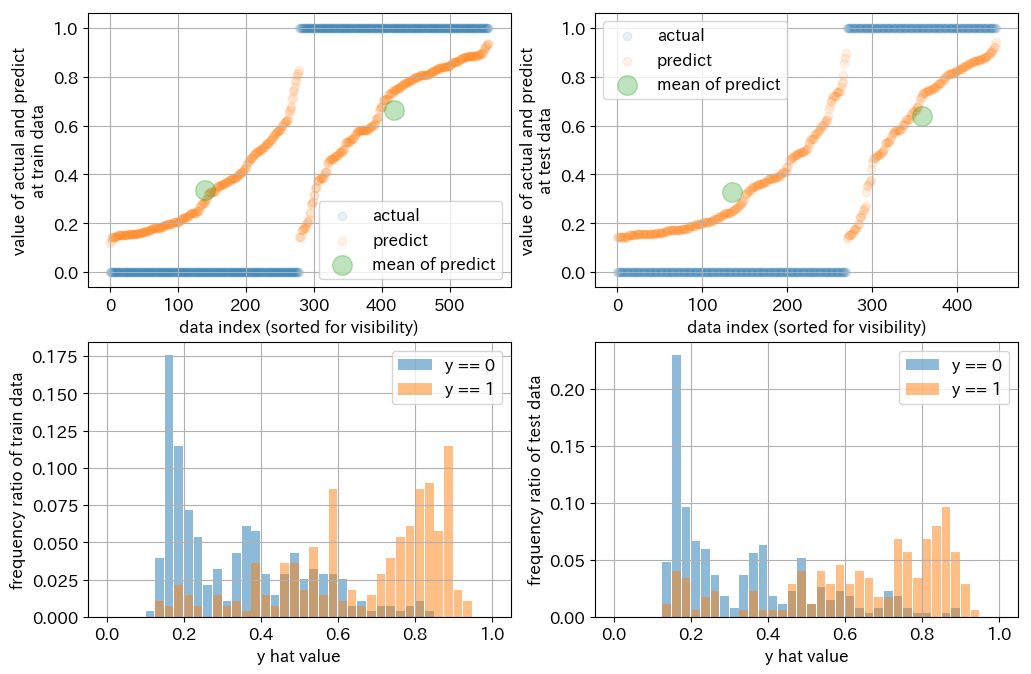

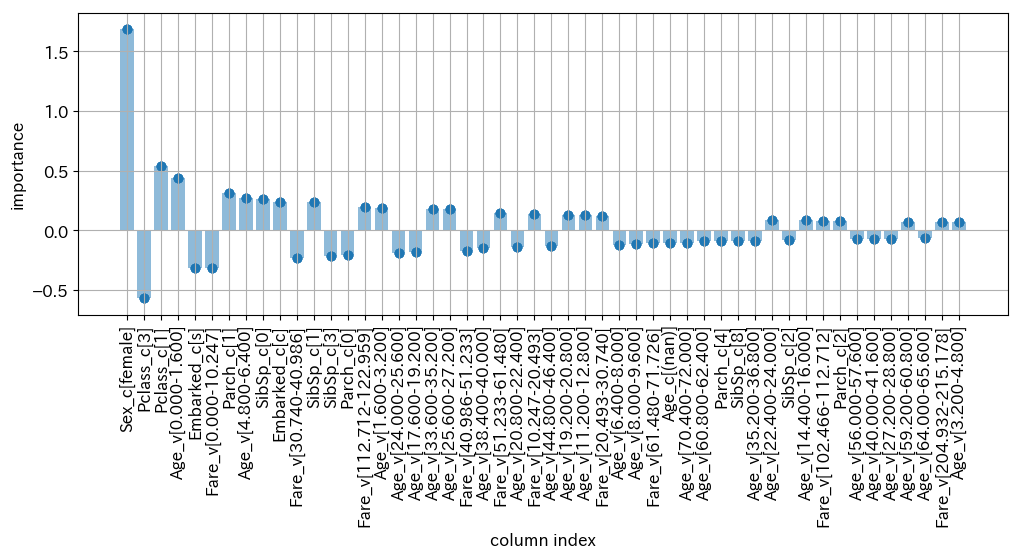



summary result


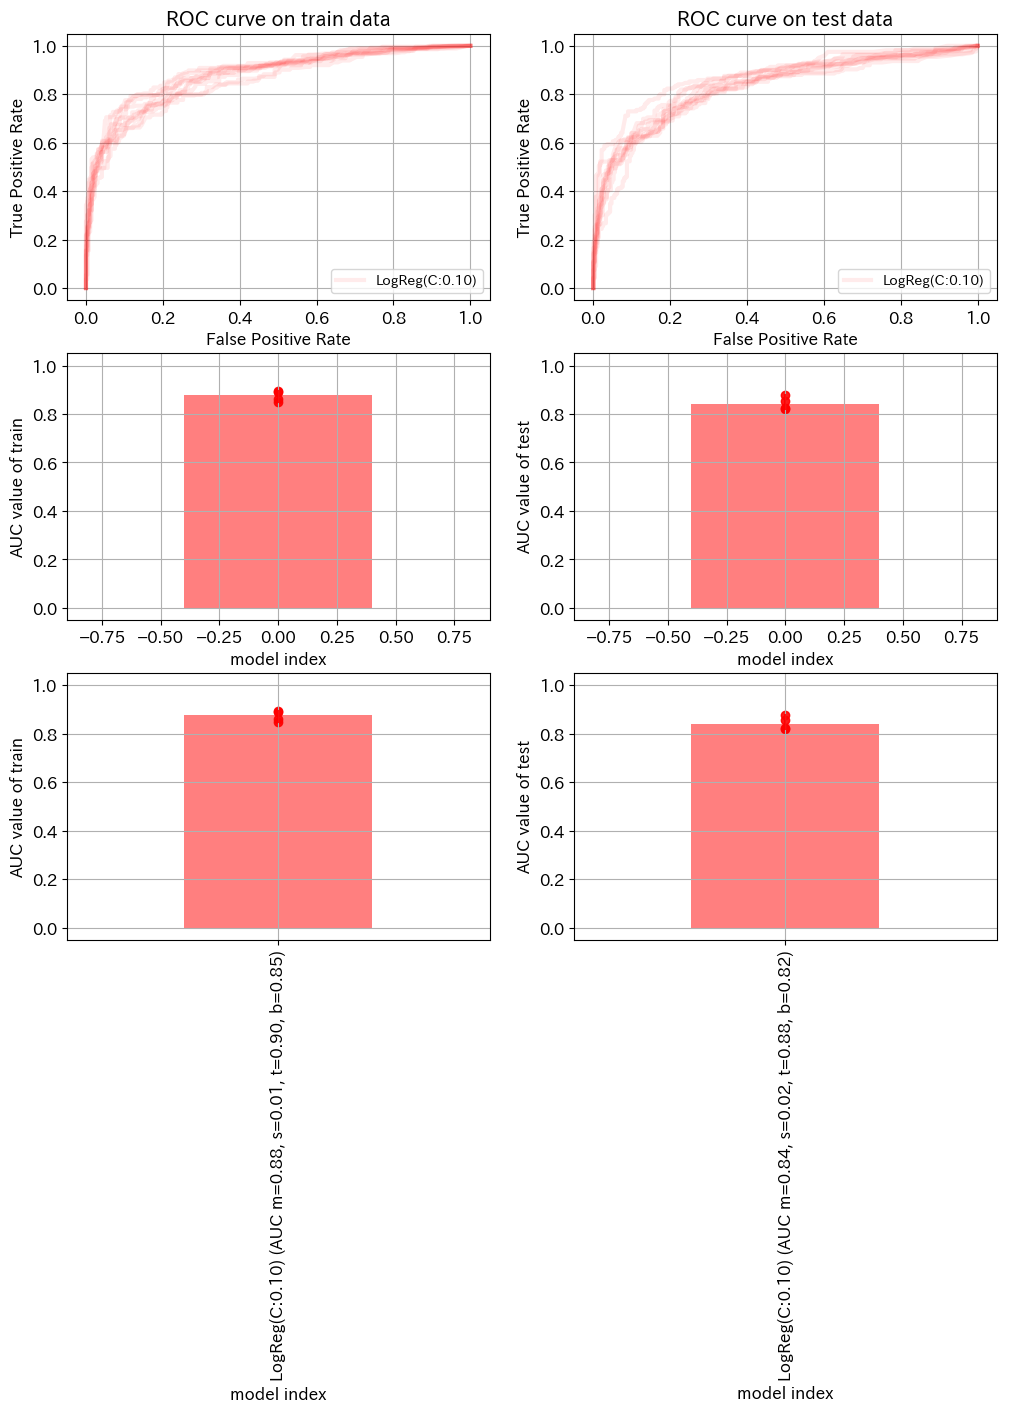

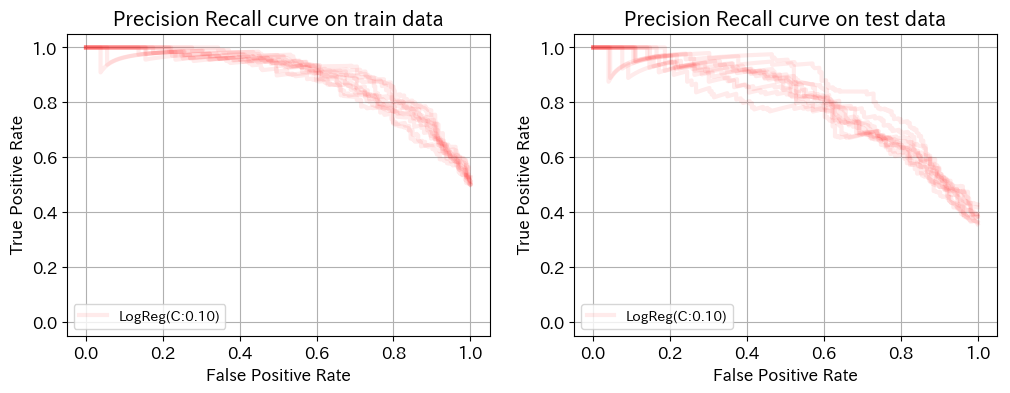

In [30]:
# [STEP 3]
# do the learning by good param setting 
rank_i       = 4 # choise method that column is small 

# 
model_i      = int(np.floor(idx_sort_auc_test[rank_i] / len(rfe_step)))
model_name_i = idx_sort_auc_test[rank_i]
rfe_step_i   = int(idx_sort_auc_test[rank_i] % len(rfe_step))

# 
model_       = model[model_i]
model_name_  = model_name_stock[idx_sort_auc_test[rank_i]]
model_name_  = model_name_[(model_name_.find('] ') + 2):]
model_name_  = model_name_[:model_name_.find('_RFE')]

# 
remain_idx_  = remain_idx[:, model_i, rfe_step_i]
X_slim       = X[:, remain_idx_]
column_name_ = column_name[remain_idx_]

# 
importance_  = np.mean(importance_stock[:, :, model_i, rfe_step_i], axis=1)

# 
print('model is ...')
print(model_)
print('')
print('use feature is ...')
for column_i in np.argsort(-np.abs(importance_)):
    if (remain_idx_[column_i]):
        print('  - %s : %.2f' % (column_name[column_i], importance_[column_i]))
print('')

# exec
(_, _, _, _, _) = ppap_tab_cls.cv_random(X                    = X_slim, 
                                         y                    = y, 
                                         model                = model_, 
                                         model_name           = model_name_, 
                                         column_name          = column_name_,
                                         sample_balance       = True, 
                                         draw_importance_rank = 50)


In [31]:
# [Step 4-3]
# try to make reduce mistake
